# Berkeley ML & AI Capstone: Fruits Classification

## Author

Matthew J. Lee<br>
BS/MS Mech/Aero Eng UC Davis, MBA Tepper, Tech Proj Mgmt UC Berkeley, ML & AI UC Berkeley<br>
Aerospace Engineer, Technical Project Manager, AI Computer Vision Engineer, Entrepreneur<br>
https://mattjlee.info

## Introduction

The goal of this capstone is to classify pictures of fruits by exploring multiple techniques and seeing which provides the best results.  We will start with a baseline model using layers of Conv2D/ Maxpooling2D and then explore different pre-trained models.<br>

## Dataset

Kaggle dataset link: https://www.kaggle.com/datasets/utkarshsaxenadn/fruits-classification/

The fruits classification dataset is from Kaggle.  It contains 10,000 images with an even number (2,000 each) of 5 different types of fruits:
- apples
- bananas
- grapes
- mangoes
- strawberries

The pictures are of various shapes, sizes, colors, and lighting conditions.  Some are pictures taken with a camera, some are computer generated, and some are drawn by hand.  All types of scenes and angles are taken of the fruits, including whole, sliced, peeled, bitten, plucked, on the tree/ vine, and arranged on dishes.  Some pictures even have false colors (like a blue apple) or are in black-and-white.  What is consistent among these images is that the fruits are true to shape, meaning there's no mashed banana, apple sauce, grape juice, or other byproducts.  If there is a picture of a byproduct (e.g. strawberry cake), the fruit is there as well.  Some images are of the full fruit, some are in bunches, some are only partially on the image or some of the fruit is not exactly true to shape because it's dipped in chocolate or something similar.<br>
![Hand drawn apple](images/Apple%20(1).png)
Hand drawn apple
![Computer generated strawberry](images/Strawberry%20(883).jpeg)
Computer generated strawberry
![Sliced and arranged apples](images/Apple%20(21).jpeg)
Sliced and arranged apples
![Blue apple](images/Apple%20(80).jpeg)
Blue apple
![Strawberry cake](images/Strawberry%20(132).jpeg)
Strawberry cake
![Chocolate dipped strawberries](images/Strawberry%20(775).jpeg)
Chocolate dipped strawberries
![Banana mostly out of the picture](images/Banana%20(3071).jpeg)
Banana mostly out of the picture

## Data Structure

The pictures have varying dimensions but all are 96 dpi vertical and horizontal resolution, have 24 bit depth, and are in jpeg format.

The data is split into 97% training, 2% validation, and 1% testing.  Since there is a total of 10,000 pictures, this means that for each of the 5 fruit classes, there are 1940 training, 40 validation, and 20 testing images.  This ensures that distribution of classes is consistent across all three sets and that the model is trained on a representative sample.

## Analysis Structure

We begin the analysis with Exploratory Data Analysis (EDA) to confirm proper data uploading.<br>

Next, we perform modeling with a baseline Conv2D/ Maxpooling2D model.  The layering and hyperparameter decisions were based on the book <i> [Deep Learning](https://www.amazon.com/Deep-Learning-Python-Francois-Chollet/dp/1617294438) </i> by Francois Chollet.<br>

After a baseline is established, we explore different pre-trained models (backbones).  We will try models that are good for diffferent purposes:
- Speed and Lightweight
  - MobileNetV2
  - EfficientNetV2B0
- Accuracy and Deep Learning
  - ResNet152V2
  - EfficientNetB7
- Multi-Scale Features
  - InceptionV3
  - Xception
- Next-Gen Performance
  - ConvNeXtBase

Here is a quick comparison chart with each of these models:


| Model              | Gen / Year       | Input Size | Params (M) | ImageNet Top-1 Acc. | Speed / Size      | Best For                                 |
|--------------------|------------------|------------|------------|----------------------|-------------------|-------------------------------------------|
| MobileNetV2        | Classic / 2018   | 224×224    | ~3.4M      | ~71.8%               | Very fast, lightweight | Mobile, embedded, small datasets      |
| EfficientNetV2B0   | Next-Gen / 2021  | 224×224    | ~7.1M      | ~82.3%               | Fast, efficient    | Fast training, limited resources          |
| ResNet152V2        | Classic / 2016   | 224×224    | ~60.2M     | ~78.3%               | Slower, large      | Very deep, general-purpose                |
| EfficientNetB7     | Classic / 2019   | 600×600    | ~66M       | ~84.4%               | Heavy compute      | Max accuracy, strong GPU                  |
| InceptionV3        | Classic / 2015   | 299×299    | ~23.8M     | ~78.8%               | Medium             | Multi-scale features, strong all-arounder |
| Xception           | Classic / 2017   | 299×299    | ~22.9M     | ~79.0%               | Medium             | Depthwise separable convs, efficient      |
| ConvNeXtBase       | Next-Gen / 2022  | 224×224    | ~88M       | ~83.1%               | High memory usage  | Modern CNN rivaling ViT                   |

## Summary of Conclusions






In [ ]:
# Common imports
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, List
from PIL import Image
import pandas as pd
from tqdm import tqdm
from glob import glob
from tensorflow import data as tfd
from tensorflow import image as tfi
import time
from tensorflow.keras.models import load_model

# Data Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import clear_output as cls

# Model Architecture
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Rescaling, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2, EfficientNetV2B0, ResNet152V2, EfficientNetB7, InceptionV3, Xception, ConvNeXtBase

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Model Hypertunning
!pip install -q keras_tuner
cls()
import keras_tuner as kt

## Load the Data

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Create useful directories

# images dataset location
dataset_dir = "/content/drive/My Drive/Colab Notebooks/Capstone/Fruits_Classification/"
#images output location
output_dir = "/content/drive/My Drive/Colab Notebooks/Capstone/images/"

# Paths to training, validation, and test sets
train_dir = os.path.join(dataset_dir, "train/")
valid_dir = os.path.join(dataset_dir, "valid/")
test_dir = os.path.join(dataset_dir, "test/")

# Define dataset directories
dataset_dirs = {
    "Train": train_dir,
    "Validation": valid_dir,
    "Test": test_dir
}



## Exploratory Data Analysis (EDA)

### Image Resolutions

First, let's take a quick look to see how many different resolutions are in the training data.

In [ ]:
# Get all image sizes
image_sizes = []

for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a folder
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            if image_path.lower().endswith((".png", ".jpg", ".jpeg")):
                with Image.open(image_path) as img:
                    image_sizes.append(img.size)  # (width, height)

# Get unique image sizes
unique_sizes = set(image_sizes)
print("Unique Image Sizes in Dataset:", unique_sizes)


Unique Image Sizes in Dataset: {(149, 110), (410, 123), (206, 244), (189, 173), (315, 160), (170, 169), (100, 92), (147, 176), (183, 108), (99, 136), (183, 117), (360, 140), (111, 110), (177, 284), (201, 251), (112, 75), (265, 168), (104, 71), (392, 129), (183, 135), (186, 271), (148, 168), (140, 164), (189, 267), (276, 183), (145, 90), (107, 225), (162, 170), (208, 137), (82, 159), (174, 144), (113, 174), (125, 139), (154, 175), (245, 195), (93, 79), (73, 110), (334, 151), (280, 180), (185, 171), (84, 116), (194, 238), (365, 138), (167, 132), (272, 185), (220, 147), (257, 196), (51, 100), (249, 183), (292, 172), (111, 69), (284, 177), (173, 291), (118, 117), (100, 69), (136, 153), (199, 200), (136, 162), (134, 89), (129, 123), (109, 154), (209, 241), (265, 163), (306, 164), (204, 144), (183, 121), (61, 95), (298, 169), (151, 159), (104, 84), (264, 176), (244, 207), (135, 300), (233, 216), (125, 125), (250, 147), (119, 194), (376, 134), (144, 138), (163, 246), (345, 146), (149, 82), (2

There is a large number of unique resolutions, to help us visualize the distribution, we'll do frequency plots on heights and widths.

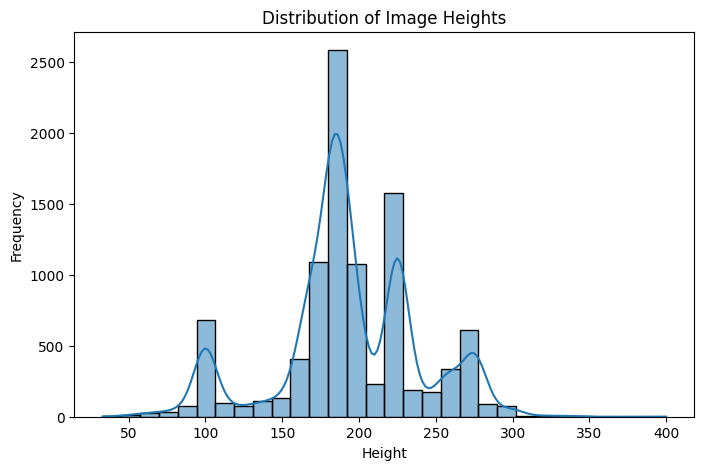

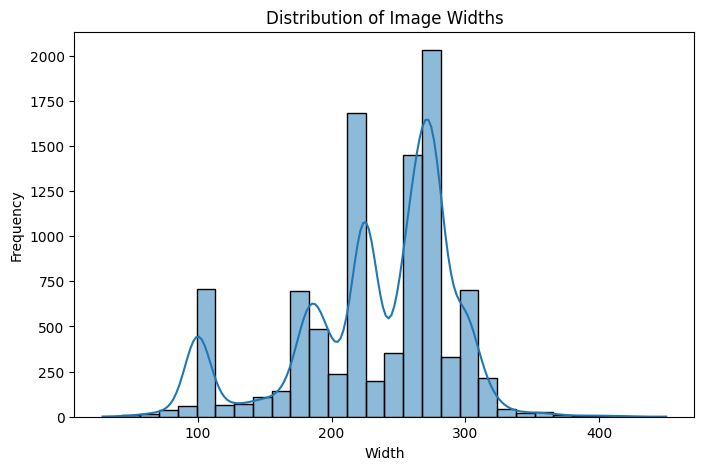

In [ ]:
# plot distribution of image heights and widths
# Convert image sizes to a DataFrame
shape_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])

# Histogram of Image Heights
plt.figure(figsize=(8, 5))
sns.histplot(shape_df["Height"], bins=30, kde=True)
plt.xlabel("Height")
plt.ylabel("Frequency")
plt.title("Distribution of Image Heights")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/DistofImageHeights.png")
plt.show()

# Histogram of Image Widths
plt.figure(figsize=(8, 5))
sns.histplot(shape_df["Width"], bins=30, kde=True)
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Distribution of Image Widths")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/DistofImageWidths.png")
plt.show()

### Class Counts and Charts

In [ ]:
# Collect the class names, ignore .ipynb_checkpoints created by Jupytr Notebook
class_names = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])
n_classes = len(class_names)

# Show
print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")

Total number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [ ]:
# Validate all files have been uploaded correctly with a table

# Get categories (Fruit classes) from the train directory
categories = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])

# Collect image counts in a DataFrame
data = []

for category in categories:
    total_count = 0
    row = {"Category": category}

    for split, path in dataset_dirs.items():
        category_path = os.path.join(path, category)
        count = len(os.listdir(category_path)) if os.path.exists(category_path) else 0
        row[split] = count
        total_count += count

    row["Total"] = total_count
    data.append(row)

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate percentages
for split in dataset_dirs.keys():
    df[f"{split} %"] = (df[split] / df["Total"]) * 100

# Display the table
print(df)

     Category  Train  Validation  Test  Total  Train %  Validation %  Test %
0       Apple   1940          40    20   2000     97.0           2.0     1.0
1      Banana   1940          40    20   2000     97.0           2.0     1.0
2       Grape   1940          40    20   2000     97.0           2.0     1.0
3       Mango   1940          40    20   2000     97.0           2.0     1.0
4  Strawberry   1940          40    20   2000     97.0           2.0     1.0


Pie graph

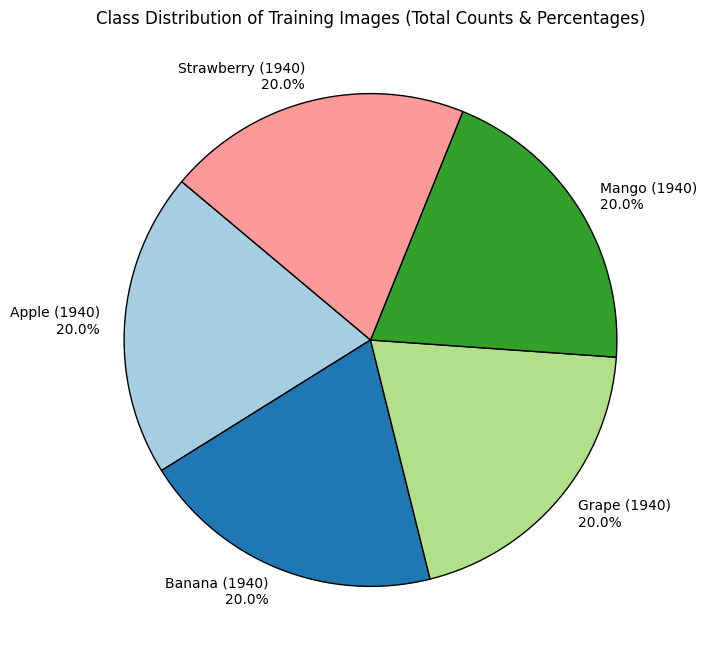

In [ ]:
# Count images in each class folder
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in class_names}

# Create labels with class names, counts, and percentages
total_images = sum(class_counts.values())
labels = [f"{cls} ({count})\n{count/total_images:.1%}" for cls, count in class_counts.items()]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values(), labels=labels, autopct='',
        startangle=140, colors=plt.cm.Paired.colors, wedgeprops={'edgecolor': 'black'})

# Title
plt.title("Class Distribution of Training Images (Total Counts & Percentages)")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Class_Dist_of_Training_Images", dpi=300)
plt.show()

Plot count and % for each fruit on separate images for clarity.

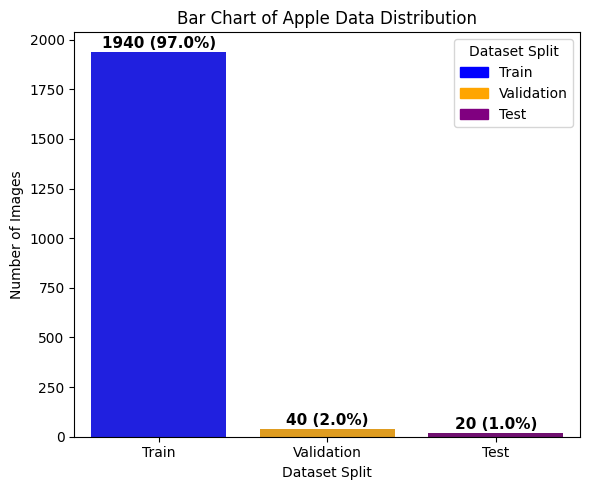

Saved: /content/drive/My Drive/Colab Notebooks/Capstone/images/Apple_distribution.png


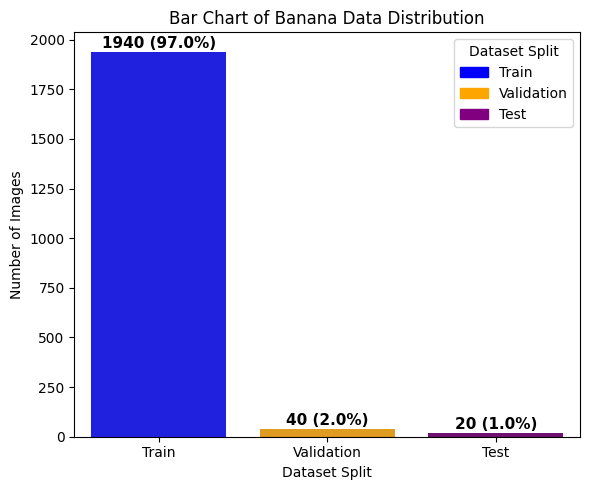

Saved: /content/drive/My Drive/Colab Notebooks/Capstone/images/Banana_distribution.png


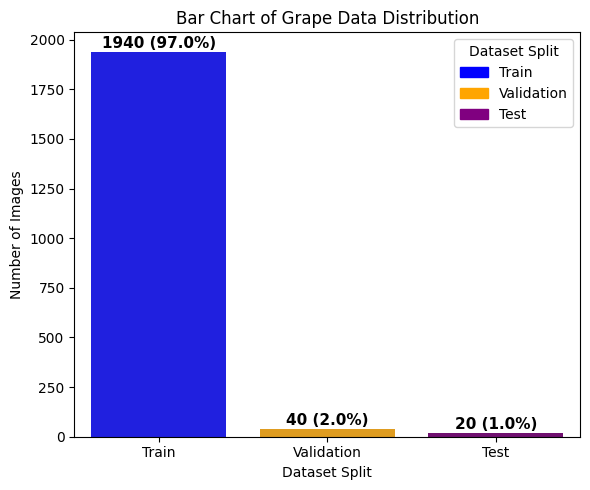

Saved: /content/drive/My Drive/Colab Notebooks/Capstone/images/Grape_distribution.png


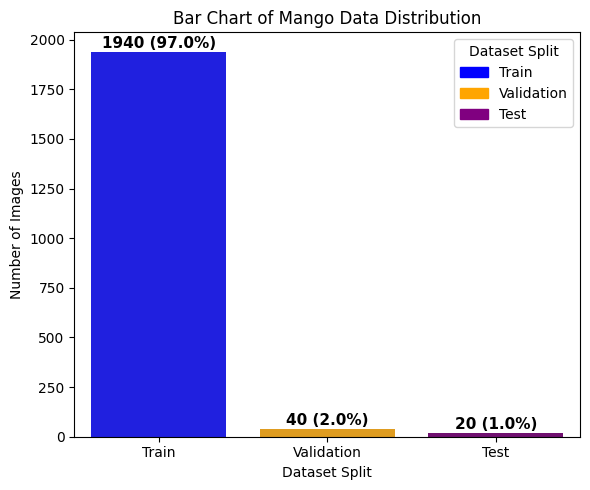

Saved: /content/drive/My Drive/Colab Notebooks/Capstone/images/Mango_distribution.png


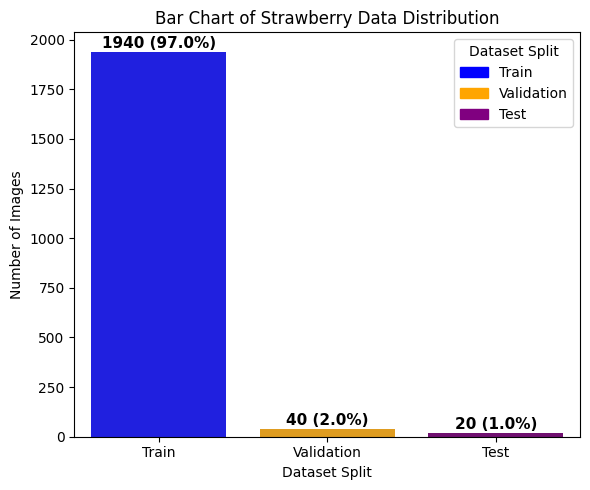

Saved: /content/drive/My Drive/Colab Notebooks/Capstone/images/Strawberry_distribution.png


In [ ]:
# Get categories (Fruit classes)
categories = sorted([d for d in os.listdir(train_dir) if not d.startswith('.')])

# Loop through each fruit category and generate a separate bar chart
for category in categories:
    # Collect image counts for each dataset split
    data = []
    total_count = 0

    for split, path in dataset_dirs.items():
        category_path = os.path.join(path, category)
        count = len(os.listdir(category_path)) if os.path.exists(category_path) else 0
        data.append([split, count])
        total_count += count

    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["Dataset", "Count"])

    # Calculate percentages
    df["Percentage"] = (df["Count"] / total_count) * 100

    # Create the bar chart
    plt.figure(figsize=(6, 5))
    ax = sns.barplot(data=df, x="Dataset", y="Count", hue="Dataset", dodge=False, palette=["blue", "orange", "purple"])

    # Add counts and percentages just above the bars
    for i, row in df.iterrows():
        ax.text(i, row["Count"] + 2, f"{row['Count']} ({row['Percentage']:.1f}%)",
                ha='center', va='bottom', fontsize=11, fontweight="bold", color="black")

    # Labels and title
    plt.xlabel("Dataset Split")
    plt.ylabel("Number of Images")
    plt.title(f"Bar Chart of {category} Data Distribution")

    # Manually add legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in ["blue", "orange", "purple"]]
    labels = ["Train", "Validation", "Test"]
    plt.legend(handles, labels, title="Dataset Split", loc="upper right")
    plt.tight_layout()

    output_path = os.path.join(output_dir, f"{category}_distribution.png")
    plt.savefig(output_path, dpi=300, bbox_inches="tight")

    # Show plot
    plt.show()

    print(f"Saved: {output_path}")


## Baseline Model: Conv2D

Fist setup random_seed = 42 for repeatability

In [ ]:
# random seed = 42 for all environments
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
# random.seed(SEED)
# os.environ['PYTHONHASHSEED'] = str(SEED)

### Conv2D model 256 pixels

In [ ]:
# train, validation, test

BATCH_SIZE = 32
IMAGE_SIZE = (256, 256)

train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)


Found 9700 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


In [ ]:
# Setup Conv2D Model, 256 pixels
conv_model = Sequential([
    Rescaling(1./255, input_shape = (256, 256, 3)),

    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    # repeat 256 layer to extract more complex features before reducing the size (similar to VGG16)
    Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    # flatten after pooling is done to prep for Dense functions
    Flatten(),

    Dense(units = 512, activation = "relu"),
    Dense(units = 5, activation = "softmax")
])
# compile model
conv_model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# show summary
conv_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,370,181 (35.74 MB)

 Trainable params: 9,370,181 (35.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train Conv2D model
conv_history = conv_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=20,
    verbose=1
)

# Evaluate on test dataset
test_loss, test_acc = conv_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Save model
conv_model.save("/content/drive/My Drive/Colab Notebooks/Capstone/models/conv2D_256pix_fruit_classifier.keras")

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 31s 73ms/step - accuracy: 0.3523 - loss: 1.4514 - val_accuracy: 0.4700 - val_loss: 1.1768
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.5325 - loss: 1.0733 - val_accuracy: 0.5900 - val_loss: 1.0266
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.5747 - loss: 0.9943 - val_accuracy: 0.6250 - val_loss: 0.9819
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6181 - loss: 0.9043 - val_accuracy: 0.5850 - val_loss: 0.9940
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6635 - loss: 0.8232 - val_accuracy: 0.6150 - val_loss: 1.0136
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.7085 - loss: 0.7289 - val_accuracy: 0.5800 - val_loss: 1.1121
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.7627 - loss: 0.6099 - val_accuracy: 0.6350 - val_loss: 1.1531
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8034 - loss: 0.5075 - 

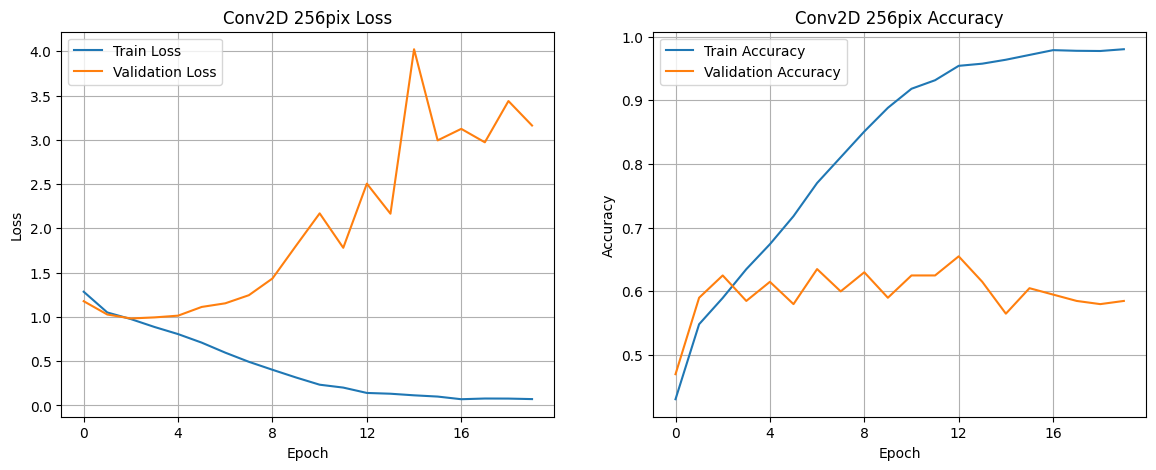

In [ ]:
# Plot Conv2D 256 px Accuracy and Loss
# conv_model = load_model("conv2D_256pix_fruit_classifier.h5")

# Plot Conv2D 256 px Accuracy and Loss
plt.figure(figsize=(14, 5))

# --- Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(conv_history.history["loss"], label="Train Loss")
plt.plot(conv_history.history["val_loss"], label="Validation Loss")
plt.xticks(np.arange(0, 20, 4))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Conv2D 256pix Loss")
plt.legend()
plt.grid(True)

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(conv_history.history["accuracy"], label="Train Accuracy")
plt.plot(conv_history.history["val_accuracy"], label="Validation Accuracy")
plt.xticks(np.arange(0, 20, 4))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Conv2D 256pix Accuracy")
plt.legend()
plt.grid(True)

plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Conv2D_256_pix_Acc_Loss.png")

### Conv2D (256 pix) model observations:

- The model is clearly subject to overfitting.  The evidence is at epoch = 2. At these locations:
  - the Validation Accuracy hits a plateua
  - Train Accuracy passes up Validation Accuracy at subsequent epochs
  - Validation Loss begins increasing rapidly  
- The Validation Accuracy hits a plateau starting at Epoch 2 and has a value of 62%.  Not a very good result.<br>


Let's try an input shape of 128 pixels and Dropout(0.5) and see if that improves overfitting.

### Conv2D model 128 Pixels

In [ ]:
# train, validation, test

BATCH_SIZE = 32
IMAGE_SIZE_128 = (128, 128)

train128_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE_128
)

valid128_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE_128
)

test128_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE_128
)

# Conv2D Model
conv128_model = Sequential([
    Rescaling(1./255, input_shape = (128, 128, 3)),

    Conv2D(filters = 32, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size = (2,2)),

    Conv2D(filters = 64, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters = 128, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    # repeat 256 layer to extract more complex features before reducing the size (similar to VGG16)
    Conv2D(filters = 256, kernel_size = (3,3), activation = "relu", padding = "same"),
    MaxPooling2D(pool_size=(2,2)),

    # flatten after pooling is done to prep for Dense functions
    Flatten(),
    # add Dropout to see if overfitting is reduced
    Dropout(0.5),

    Dense(units = 512, activation = "relu"),
    Dense(units = 5, activation = "softmax")
])
# compile model
conv128_model.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# show summary
conv128_model.summary()

# Train model
conv128_history = conv128_model.fit(
    train128_dataset,
    validation_data=valid128_dataset,
    epochs=20,
    verbose=1
)

# Evaluate on test dataset
test_loss, test_acc = conv128_model.evaluate(test128_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Save model
conv128_model.save("/content/drive/My Drive/Colab Notebooks/Capstone/models/conv2D_128pix_fruit_classifier.keras")

Found 9700 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,078,725 (11.74 MB)

 Trainable params: 3,078,725 (11.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 218s 691ms/step - accuracy: 0.3942 - loss: 1.3529 - val_accuracy: 0.4700 - val_loss: 1.1345
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5393 - loss: 1.0550 - val_accuracy: 0.5650 - val_loss: 1.0302
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.5917 - loss: 0.9884 - val_accuracy: 0.6750 - val_loss: 0.9135
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6454 - loss: 0.8946 - val_accuracy: 0.6900 - val_loss: 0.8472
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.6784 - loss: 0.8225 - val_accuracy: 0.6900 - val_loss: 0.8718
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7002 - loss: 0.7853 - val_accuracy: 0.6500 - val_loss: 0.8481
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7179 - loss: 0.7433 - val_accuracy: 0.6950 - val_loss: 0.7779
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7320 - loss: 0.6738 

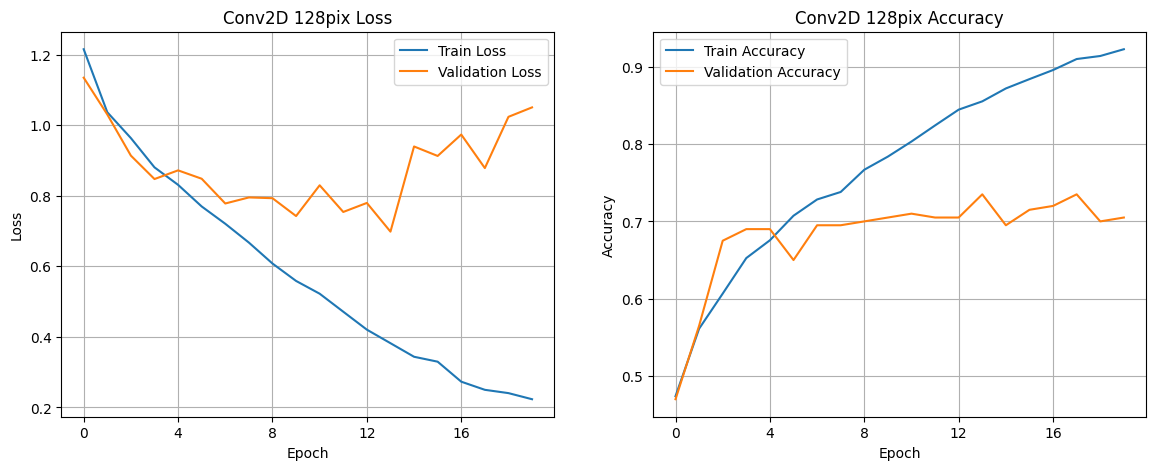

In [ ]:
# Plot Conv2D 128 px accuracies
# Plot Conv2D 256 px Accuracy and Loss
plt.figure(figsize=(14, 5))

# --- Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(conv128_history.history["loss"], label="Train Loss")
plt.plot(conv128_history.history["val_loss"], label="Validation Loss")
plt.xticks(np.arange(0, 20, 4))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Conv2D 128pix Loss")
plt.legend()
plt.grid(True)

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(conv128_history.history["accuracy"], label="Train Accuracy")
plt.plot(conv128_history.history["val_accuracy"], label="Validation Accuracy")
plt.xticks(np.arange(0, 20, 4))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Conv2D 128pix Accuracy")
plt.legend()
plt.grid(True)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Conv2D_128_pix_Acc_Loss.png")

### Conv2D 128 px observations:

- decreasing to 128 pixels and adding Dropout(0.5) reduced overfitting
- the Validation Accuracy only peaked at around 75%, still not a good result

## Backbone (Pre-Trained) Models

- Speed and Lightweight
  - MobileNetV2
  - EfficientNetV2B0
- Accuracy and Deep Learning
  - ResNet152V2
  - EfficientNetB7
- Multi-Scale Features
  - InceptionV3
  - Xception
- Next-Gen Performance
  - ConvNeXtBase

### Backbones Setup

In [ ]:
# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 9700 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.


In [ ]:
# create backbone models
backbone_names = [
    "MobileNetV2",
    "EfficientNetV2B0",
    "ResNet152V2",
    "EfficientNetB7",
    "InceptionV3",
    "Xception",
    "ConvNeXtBase",
]

backbone_models = [
    MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    EfficientNetV2B0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    ResNet152V2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    EfficientNetB7(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    InceptionV3(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    Xception(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
    ConvNeXtBase(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),
]

for backbone in backbone_models:
    backbone.trainable = False

<ipython-input-9-8df039d7e73a>:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights="imagenet"),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Record the learing curve for all the backbones
HISTORIES = {}
TRAINING_TIMES = {}

# Loop over all the backbones
for name, backbone in zip(backbone_names, backbone_models):

    # Show
    print(f"Training: {name}\n")

    # Make a small model
    model = Sequential([
        Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    start_time = time.time()

    # Train the model
    model_history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        verbose=1
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    TRAINING_TIMES[name] = elapsed_time

    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_dataset)

    # Store the history
    HISTORIES[name] = model_history.history
    model.save(f"/content/drive/My Drive/Colab Notebooks/Capstone/models/{name}_model.keras")

Training: MobileNetV2

Epoch 1/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 52s 121ms/step - accuracy: 0.6159 - loss: 1.0204 - val_accuracy: 0.8450 - val_loss: 0.4047
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8217 - loss: 0.4961 - val_accuracy: 0.8650 - val_loss: 0.3385
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8416 - loss: 0.4464 - val_accuracy: 0.8650 - val_loss: 0.3138
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8513 - loss: 0.4133 - val_accuracy: 0.8950 - val_loss: 0.2968
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8567 - loss: 0.4007 - val_accuracy: 0.8850 - val_loss: 0.2839
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8587 - loss: 0.3914 - val_accuracy: 0.8750 - val_loss: 0.2912
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8675 - loss: 0.3694 - val_accuracy: 0.9000 - val_loss: 0.2684
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 

In [ ]:
# load saved models
# for name in backbone_names:
#     # Load model
#     model_path = f"{model_dir}/{name}_model.keras"
#     if os.path.exists(model_path):
#         model = load_model(model_path)

#         # Optional: add to a model dictionary if needed
#         # MODELS[name] = model  # ← only if you want to reuse them

#         # Try to load corresponding history if saved separately
#         history_path = f"{model_dir}/{name}_history.json"
#         if os.path.exists(history_path):
#             with open(history_path, "r") as f:
#                 HISTORIES[name] = json.load(f)

# Summary table
# Create a list to hold rows of data
summary_data = []

# Loop through each model
for name in HISTORIES.keys():
    history = HISTORIES[name]
    training_time_min = TRAINING_TIMES.get(name, 0) / 60

    max_train_acc = max(history["accuracy"])
    median_train_acc = np.median(history["accuracy"])

    max_val_acc = max(history["val_accuracy"])
    median_val_acc = np.median(history["val_accuracy"])

    summary_data.append({
        "Model": name,
        "Max Train Accuracy": round(max_train_acc, 4),
        "Median Train Accuracy": round(median_train_acc, 4),
        "Max Val Accuracy": round(max_val_acc, 4),
        "Median Val Accuracy": round(median_val_acc, 4),
        "Training Time (min)": round(training_time_min, 2)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

Model  Max Train Accuracy  Median Train Accuracy  \
0       MobileNetV2              0.8684                 0.8640   
1  EfficientNetV2B0              0.2177                 0.2126   
2       ResNet152V2              0.8773                 0.8695   
3    EfficientNetB7              0.2120                 0.2070   
4       InceptionV3              0.8607                 0.8578   
5          Xception              0.8905                 0.8822   
6      ConvNeXtBase              0.7774                 0.7706   

   Max Val Accuracy  Median Val Accuracy  Training Time (min)  
0             0.910                0.895                 5.00  
1             0.270                0.205                 5.21  
2             0.895                0.880                 5.23  
3             0.250                0.215                 8.41  
4             0.915                0.895                 4.90  
5             0.915                0.885                 4.99  
6             0.815                0.800                 5.55

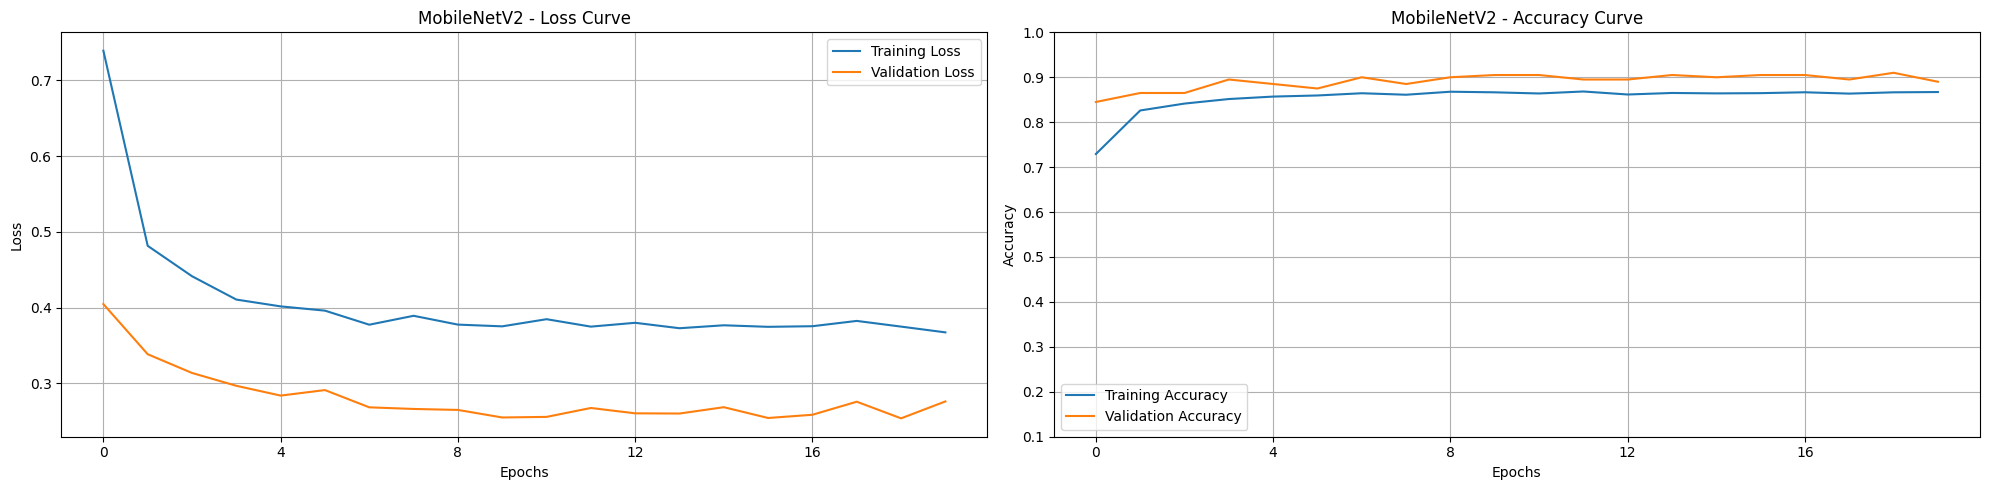

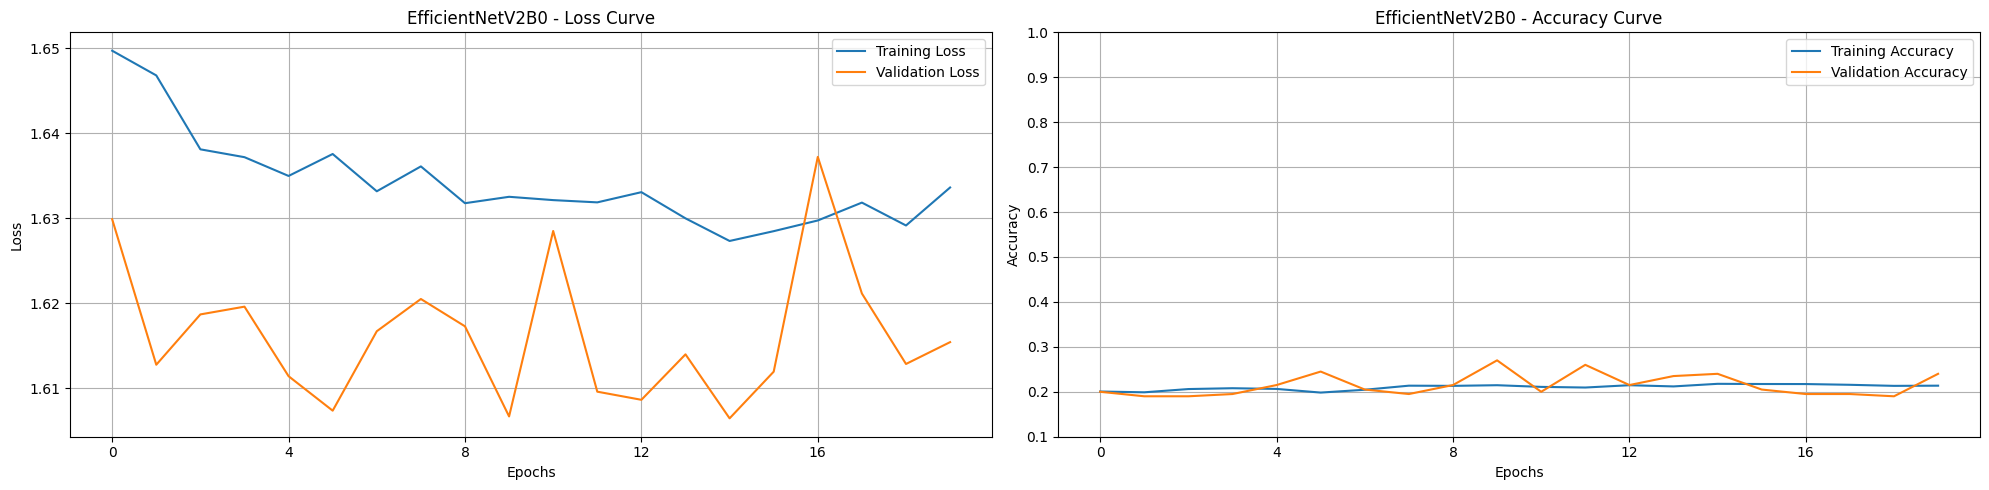

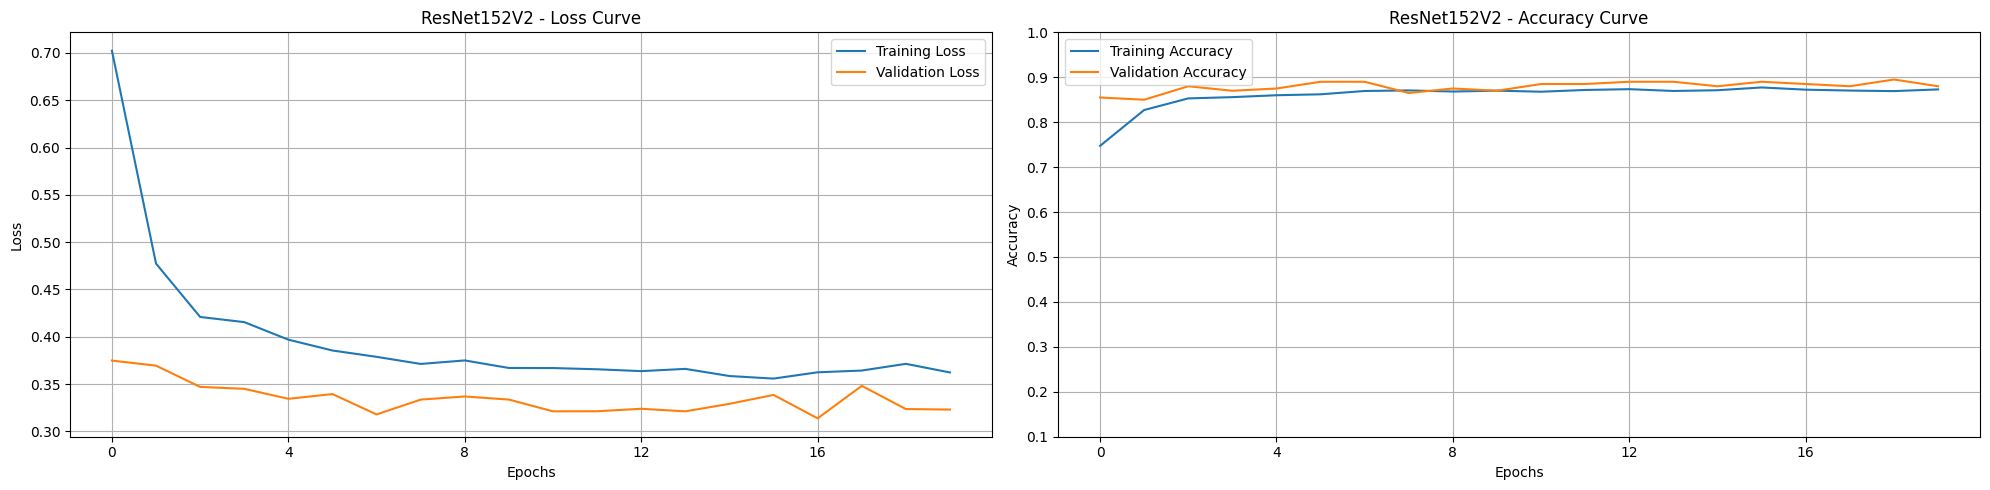

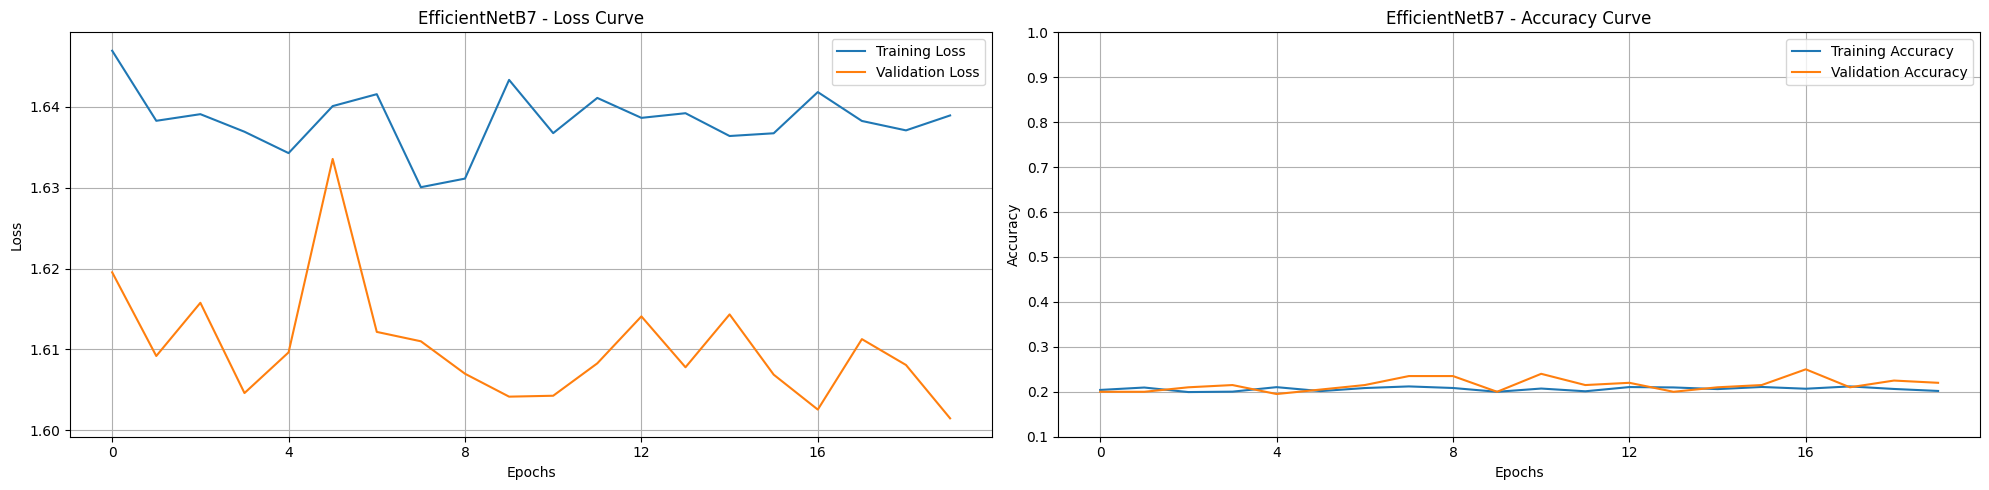

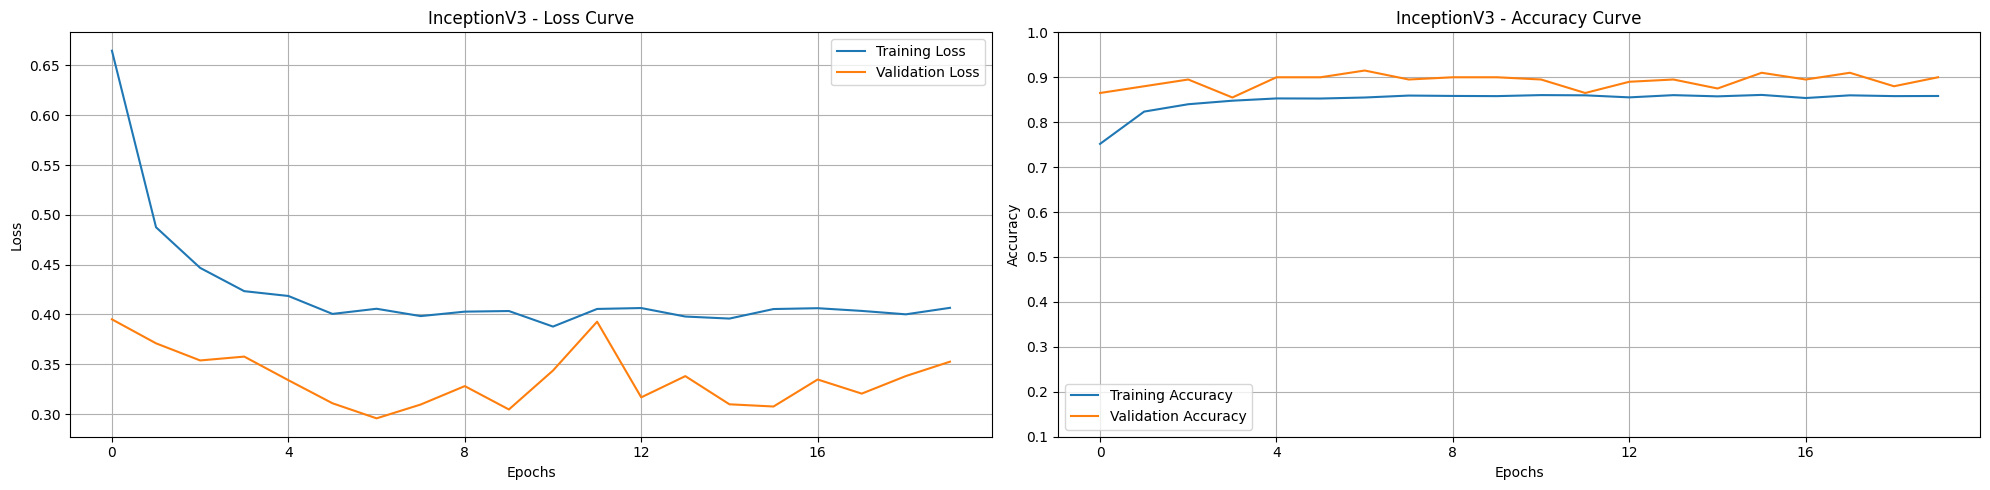

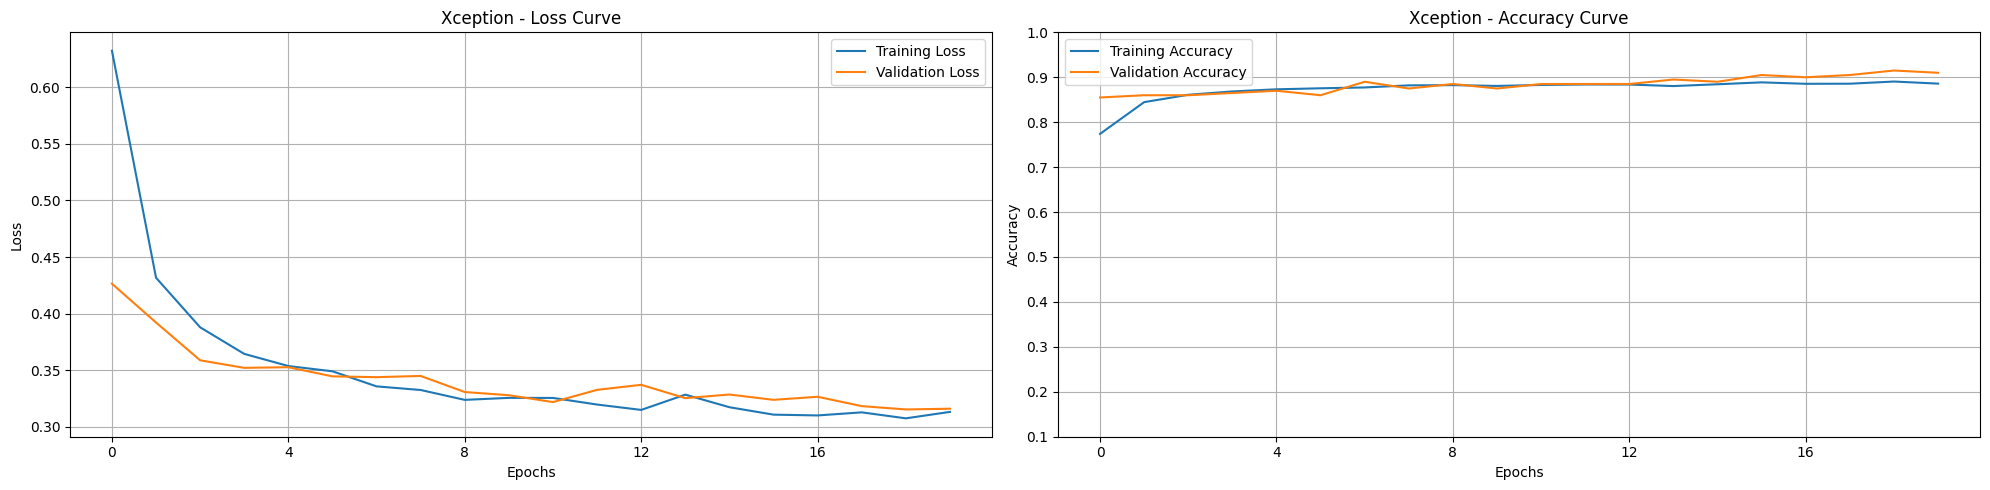

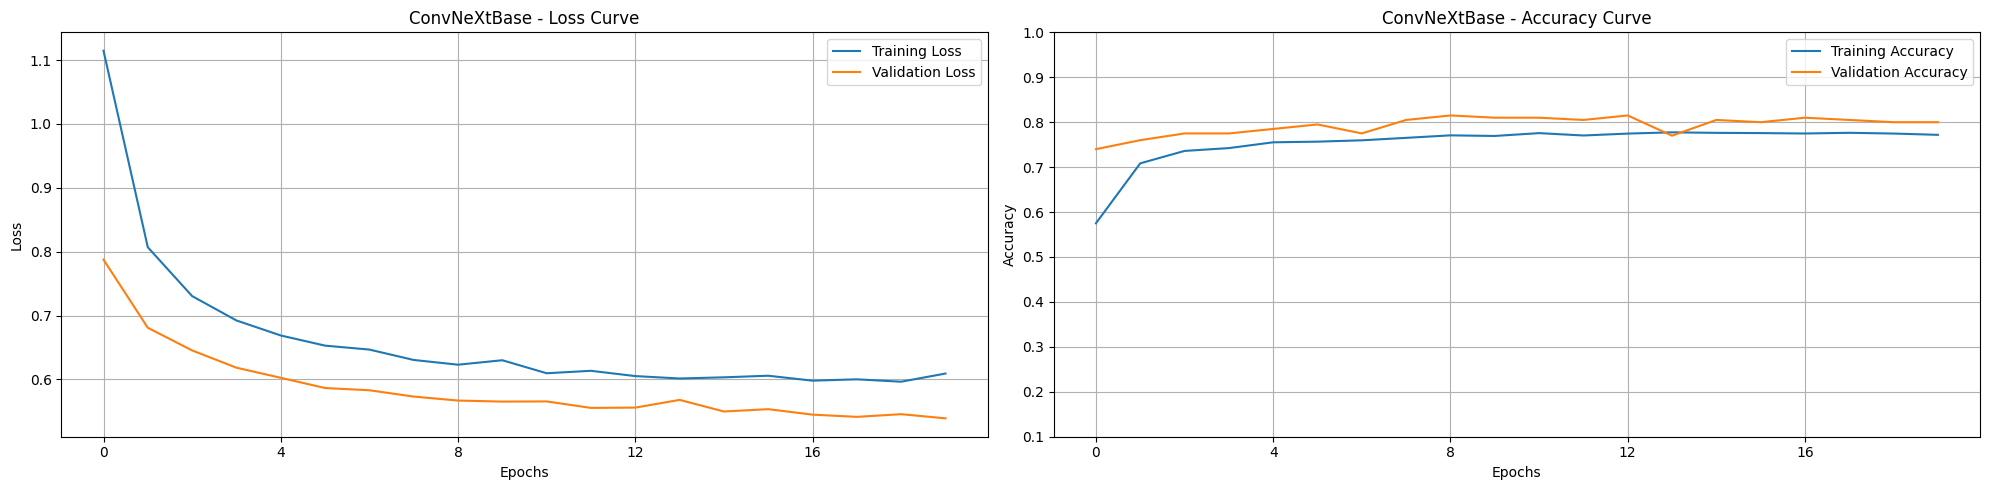

In [ ]:
# Plots, loop over the model training curves
for name, history in HISTORIES.items():

    # Create a new figure for each backbone
    plt.figure(figsize=(20, 5))

    # --- Loss subplot ---
    plt.subplot(1, 2, 1)
    plt.title(f"{name} - Loss Curve")
    plt.plot(history['loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, 20, 4))
    plt.grid(True)
    plt.legend()

    # --- Accuracy subplot ---
    plt.subplot(1, 2, 2)
    plt.title(f"{name} - Accuracy Curve")
    plt.plot(history['accuracy'], label="Training Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0.1, 1.0])
    plt.xticks(np.arange(0, 20, 4))
    plt.grid(True)
    plt.legend()

    #save the plot
    save_path = f"/content/drive/My Drive/Colab Notebooks/Capstone/images/{name}_Acc_Loss.png"
    plt.tight_layout()
    plt.savefig(save_path)

    # show the combined plots
    plt.show()

### Backbones Observations

#### Overfitting

  - All of the models had Validation Accuracy at or above Training Accuracy, so we aren't concerned about overfitting

#### Median Valitation Accuracy

- The best metric for evaluating these models is the **Median Validation Accuracy**
- As we saw before, the Training Accuracy can be subject to overfitting, so Validation Accuracy is more appropriate
- Since the Validation Accuracies show plateus, the median values will tell the best story of what the model delivers consistently
- The **highest median Training Accuracy** was achieved with **MobileNetV2** with a value of **90%**
  -  **MobileNetV2** had a **maximum Validation Accuracy of 92%**
- Not far behinda are InceptionV3, Xception, and Resnet152V2 with median Training Accuracies of 89.5%, 88.5%, and 88.5%, respectively
- The poorest models were the EfficientNet variants (EfficientNetV2B0 and EfficienNetB7) which hovered around median Validation Accuracy = 21%

#### Training Time

- All of the models trained at around 5 minutes, except EfficientNetB7 took about 8 1/2 minutes.


## Hypertuning MobileNetV2

- MobileNetV2 seemed to be the slight winner in all of our trials (training off)
- hypertune dropout (0.3 - 0.7), units (64 - 512), and learning rate (1e-2 - 1e-5)
- stop after 5 epochs if validation loss is not improving

In [ ]:
# Hypertuning for MobileNetV2

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
SEED = 42

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

# ✅ Optional performance boost
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
valid_dataset = valid_dataset.prefetch(AUTOTUNE)
test_dataset = test_dataset.prefetch(AUTOTUNE)

# hyperparameters: dropout, units, learning rates
def build_model(hp):
    backbone = MobileNetV2(
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet"
    )
    backbone.trainable = False

    model = Sequential([
        Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        backbone,
        GlobalAveragePooling2D(),
        Dropout(hp.Float("dropout", 0.3, 0.7, step=0.1)),
        Dense(
            hp.Int("units", min_value=64, max_value=512, step=64),
            activation="relu"
        ),
        Dense(5, activation="softmax")
    ])

    model.compile(
        optimizer=Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4, 1e-5])),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

# initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=50,
    factor=3,
    directory="kt_dir",
    project_name="mobilenet_tuning"
)

# Set up early stopping
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,                # Stop after 5 epochs without improvement
#     restore_best_weights=True  # Roll back to best model weights
# )

tuner.search(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
#    callbacks=[early_stop]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Optional: fine-tune longer
history = best_model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50,
#    callbacks=[early_stop]
)

# Evaluate
test_loss, test_acc = best_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")
# Print the best values
print("Best Hyperparameters:")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Units: {best_hps.get('units')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

# Save the best model
best_model.save("/content/drive/My Drive/Colab Notebooks/Capstone/models/Best_MobileNetV2_tuned_model.keras")

Trial 80 Complete [00h 04m 05s]
val_accuracy: 0.8050000071525574

Best val_accuracy So Far: 0.9399999976158142
Total elapsed time: 02h 27m 17s

Search: Running Trial #81

Value             |Best Value So Far |Hyperparameter
0.6               |0.5               |dropout
448               |64                |units
0.01              |0.001             |learning_rate
17                |50                |tuner/epochs
0                 |17                |tuner/initial_epoch
1                 |3                 |tuner/bracket
0                 |3                 |tuner/round

Epoch 1/17
304/304 ━━━━━━━━━━━━━━━━━━━━ 29s 70ms/step - accuracy: 0.6674 - loss: 1.6439 - val_accuracy: 0.8550 - val_loss: 0.4060
Epoch 2/17
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.8027 - loss: 0.5530 - val_accuracy: 0.8400 - val_loss: 0.4532
Epoch 3/17
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.8109 - loss: 0.5233 - val_accuracy: 0.8550 - val_loss: 0.4151
Epoch 4/17
270/304 ━━━━━━━━━━━━━

In [ ]:
# reset tuner if necessary
# tuner.results_summary()
# import shutil
# shutil.rmtree("kt_dir/mobilenet_tuning", ignore_errors=True)

Results summary
Results in kt_dir/mobilenet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0024 summary
Hyperparameters:
dropout: 0.3
units: 512
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.9399999976158142

Trial 0021 summary
Hyperparameters:
dropout: 0.3
units: 512
learning_rate: 0.0001
tuner/epochs: 7
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.9399999976158142

Trial 0017 summary
Hyperparameters:
dropout: 0.3
units: 256
learning_rate: 0.001
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.9300000071525574

Trial 0028 summary
Hyperparameters:
dropout: 0.5
units: 320
learning_rate: 0.0001
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.925000011920929

Trial 0012 summary
Hyperparameters:
dropout: 0.4
units: 384
learning_rate: 0.001
tuner/epochs: 7
tuner/initial_epo

In [ ]:
# load saved model
# best_model = load_model("/content/drive/My Drive/Colab Notebooks/Capstone/models/Best_MobileNetV2_tuned_model.keras")

plt.figure(figsize=(14, 5))

# --- Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MobileNetV2 - Best Loss Curve")
plt.xticks(np.arange(0, 50, 5))
plt.grid(True)
plt.legend()

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.1, 1.0])
plt.title("MobileNetV2 - Best Accuracy Curve")
plt.xticks(np.arange(0, 50, 5))
plt.grid(True)
plt.legend()

# Save and show plot
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Tuned_MobileNet_Acc_Loss.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:

              precision    recall  f1-score   support

       Apple     1.0000    0.8500    0.9189        20
      Banana     1.0000    1.0000    1.0000        20
       Grape     0.9524    1.0000    0.9756        20
       Mango     0.8696    1.0000    0.9302        20
  Strawberry     1.0000    0.9500    0.9744        20

    accuracy                         0.9600       100
   macro avg     0.9644    0.9600    0.9598       100
weighted avg     0.9644    0.9600    0.9598       100



<Figure size 800x600 with 0 Axes>

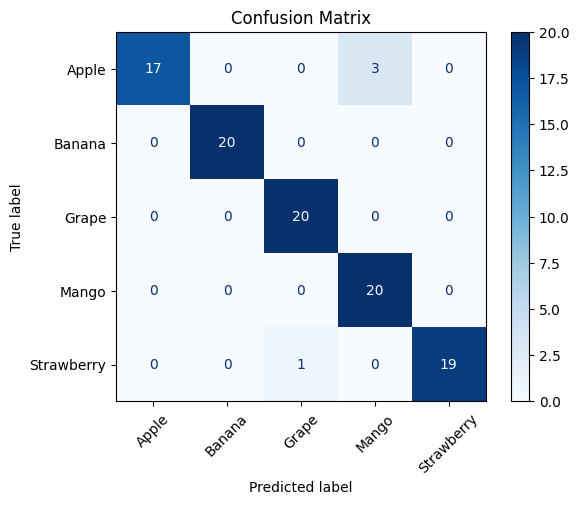

In [ ]:
# Performance Metrics & Confusion Matrix

# load saved model
best_model = load_model("/content/drive/My Drive/Colab Notebooks/Capstone/models/Best_MobileNetV2_tuned_model.keras")

# Get class names
class_names = test_dataset.class_names

# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Best_MobileNet_ConfMatrix.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


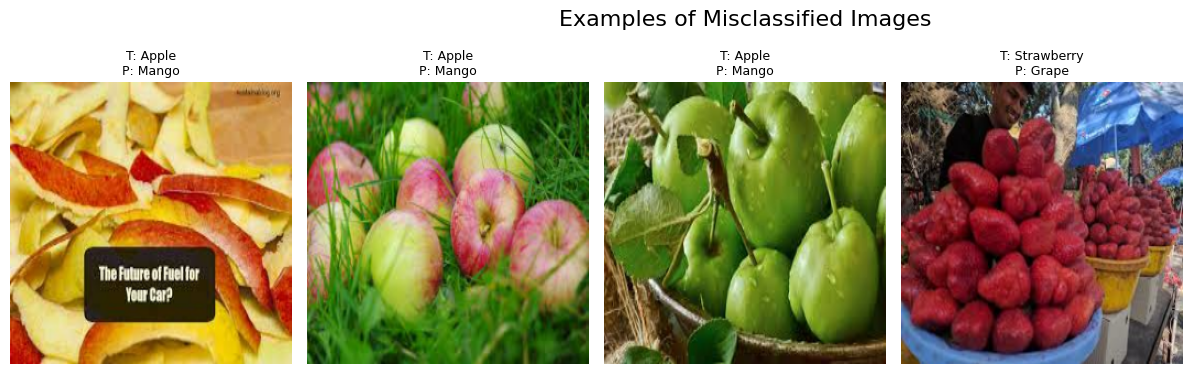

In [ ]:
# Show mis-classified images

# Collect images, true labels, and predicted labels
misclassified_images = []
misclassified_preds = []
misclassified_trues = []

for images, labels in test_dataset:
    preds = best_model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for img, true_label, pred_label in zip(images, labels.numpy(), pred_labels):
        if true_label != pred_label:
            misclassified_images.append(img.numpy())
            misclassified_trues.append(true_label)
            misclassified_preds.append(pred_label)

# Display first N misclassified images
N = 10
plt.figure(figsize=(15, 8))
for i in range(min(N, len(misclassified_images))):
    plt.subplot(2, N // 2, i + 1)
    plt.imshow(misclassified_images[i].astype("uint8"))
    true_name = class_names[misclassified_trues[i]]
    pred_name = class_names[misclassified_preds[i]]
    plt.title(f"T: {true_name}\nP: {pred_name}", fontsize=9)
    plt.axis("off")

plt.suptitle("Examples of Misclassified Images", fontsize=16)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/Best_MobileNet_Mislabeled.png")
plt.show()

## Extra Investigations

Let's answer some burning questions:

- Why were EfficientNet models so poor?  
  - Since we have training off, none of these models are actually learning.  Without learning, the models are limted to their original training dataset
    - Let's run models with **training on** to test this theory
  - The dataset is similar to ImageNet, which has 20 fruit classes.  4/5 fruit classes in EfficientNet overlap with this Kaggle dataset: bananas, apples, strawberries, and mangoes (grapes are missing).  
    - So, why isn't the accuracy 4/5 or 80%?  
      - Let's create a **Confusion Matrix** to see what is happening
      - Let's also look at some **examples of mis-classification**
- Why was EfficientNetB7 so slow compared to the other backbones?
  - EfficientNetB7 is setup to use larger images (600 x 600) than the other models and is trained on more parameters (no analysis needed)

### Backbones with Training On

- turn trainable = True on

In [ ]:
for backbone in backbone_models:
    backbone.trainable = True

# Record the learing curve for all the backbones
HISTORIES = {}
TRAINING_TIMES = {}

# Loop over all the backbones
for name, backbone in zip(backbone_names, backbone_models):

    # Show
    print(f"Training: {name}\n")

    # Make a small model
    model = Sequential([
        Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(5, activation='softmax')
    ])

    # Compile the model
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )

    start_time = time.time()

    # create early stop after 5 epochs if validation accuracy is not improving
    # early_stop = EarlyStopping(monitor='val_accuracy',patience=5, restore_best_weights=True)

    # Train the model
    model_history = model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        # callbacks=[early_stop], # stop early if needed
        verbose=1
    )

    end_time = time.time()
    elapsed_time = end_time - start_time
    TRAINING_TIMES[name] = elapsed_time

    # Evaluate on test dataset
    test_loss, test_acc = model.evaluate(test_dataset)

    # Store the history
    HISTORIES[name] = model_history.history
    model.save(f"/content/drive/My Drive/Colab Notebooks/Capstone/models/{name}_Train_On_model.keras")

Training: MobileNetV2

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 254s 626ms/step - accuracy: 0.7465 - loss: 0.7336 - val_accuracy: 0.3350 - val_loss: 11.1726
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.8235 - loss: 0.5092 - val_accuracy: 0.4400 - val_loss: 7.0973
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.8629 - loss: 0.4116 - val_accuracy: 0.2700 - val_loss: 15.2267
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.8901 - loss: 0.3282 - val_accuracy: 0.2800 - val_loss: 12.8417
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9141 - loss: 0.2605 - val_accuracy: 0.2450 - val_loss: 11.0452
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.9169 - loss: 0.2445 - val_accuracy: 0.2750 - val_loss: 10.5640
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9297 - loss: 0.2201 - val_accuracy: 0.3200 - val_loss: 6.9409
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.9223 - loss: 0.2427 - val_

In [ ]:
# Summary table
# Create a list to hold rows of data
summary_data = []

# Loop through each model
for name in HISTORIES.keys():
    history = HISTORIES[name]
    training_time_min = TRAINING_TIMES.get(name, 0) / 60

    max_train_acc = max(history["accuracy"])
    median_train_acc = np.median(history["accuracy"])

    max_val_acc = max(history["val_accuracy"])
    median_val_acc = np.median(history["val_accuracy"])

    summary_data.append({
        "Model": name,
        "Max Train Accuracy": round(max_train_acc, 4),
        "Median Train Accuracy": round(median_train_acc, 4),
        "Max Val Accuracy": round(max_val_acc, 4),
        "Median Val Accuracy": round(median_val_acc, 4),
        "Training Time (min)": round(training_time_min, 2)
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

Model  Max Train Accuracy  Median Train Accuracy  \
0       MobileNetV2              0.9709                 0.9427   
1  EfficientNetV2B0              0.9860                 0.9690   
2       ResNet152V2              0.9625                 0.8659   
3    EfficientNetB7              0.9826                 0.9718   
4       InceptionV3              0.9769                 0.9364   
5          Xception              0.9890                 0.9706   
6      ConvNeXtBase              0.2046                 0.1997   

   Max Val Accuracy  Median Val Accuracy  Training Time (min)  
0             0.765               0.4650                 8.55  
1             0.375               0.2050                 6.84  
2             0.790               0.7025                15.02  
3             0.695               0.2150                26.21  
4             0.895               0.8200                 7.04  
5             0.925               0.8850                 8.90  
6             0.200               0.2000                37.63

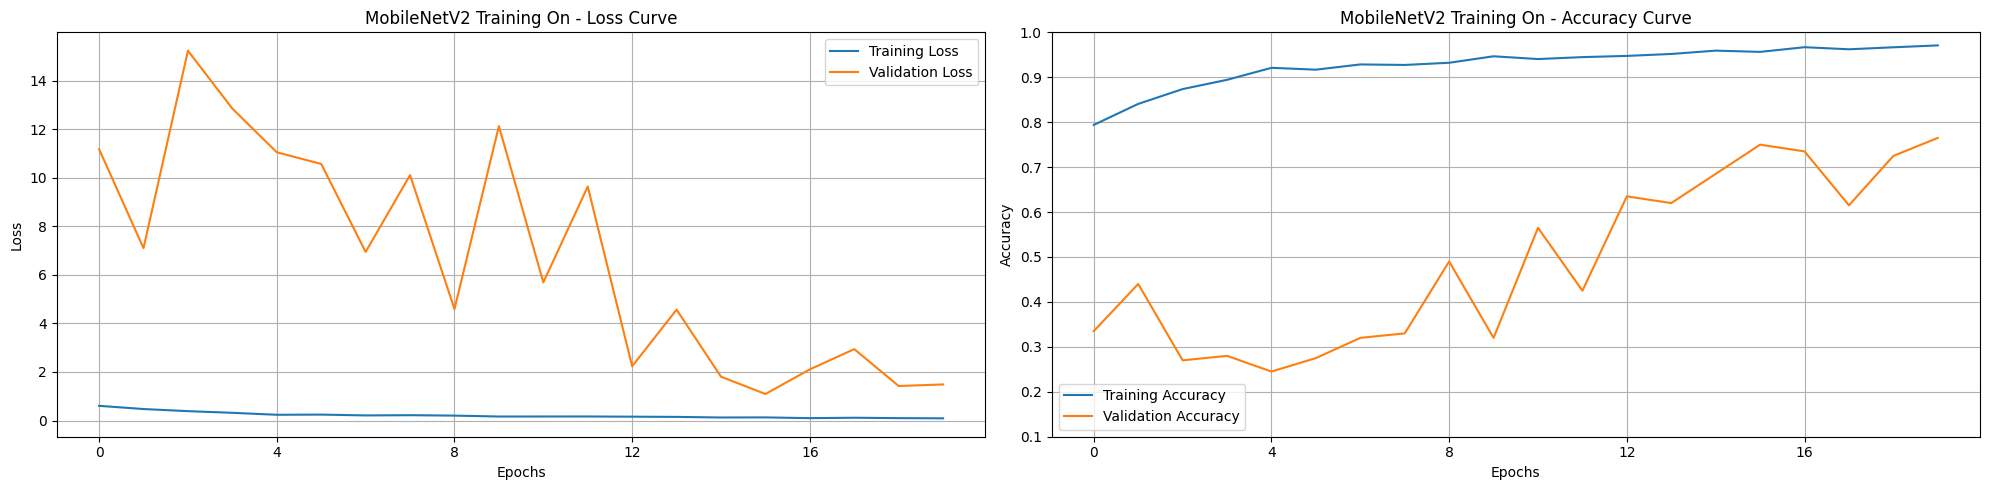

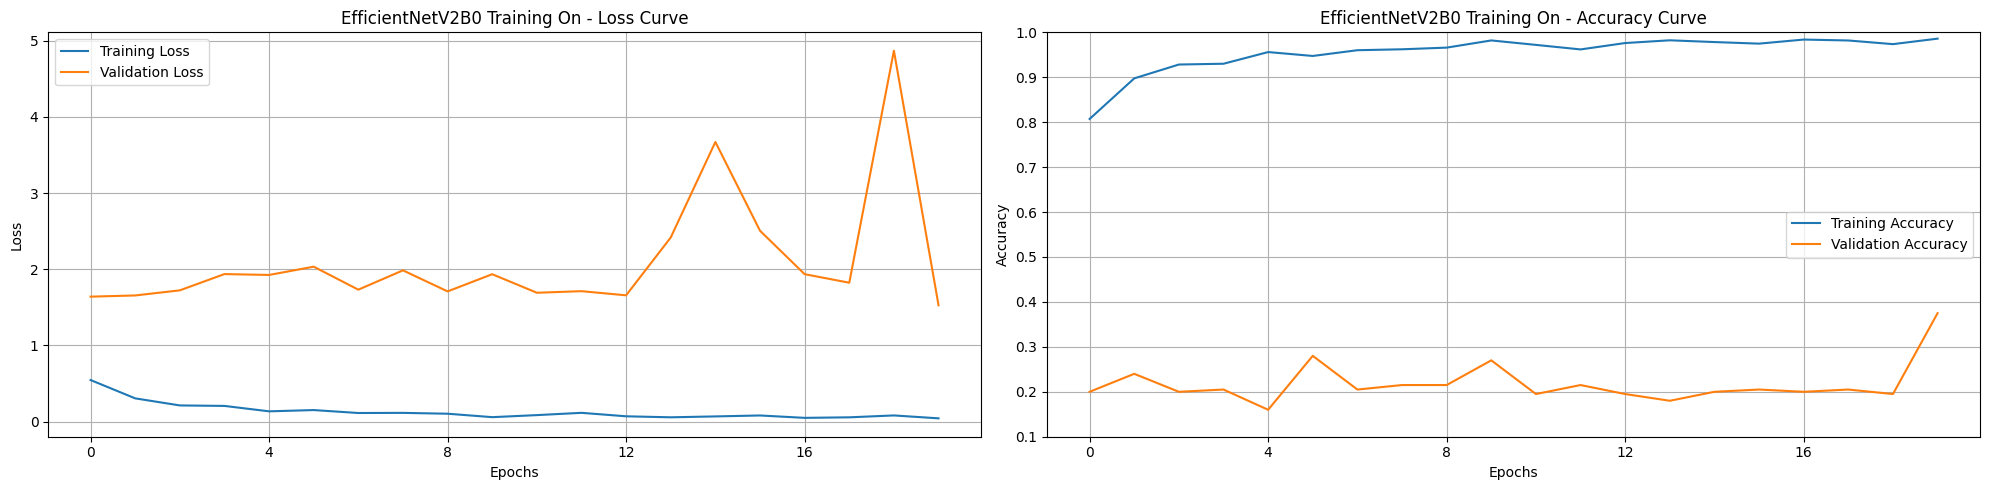

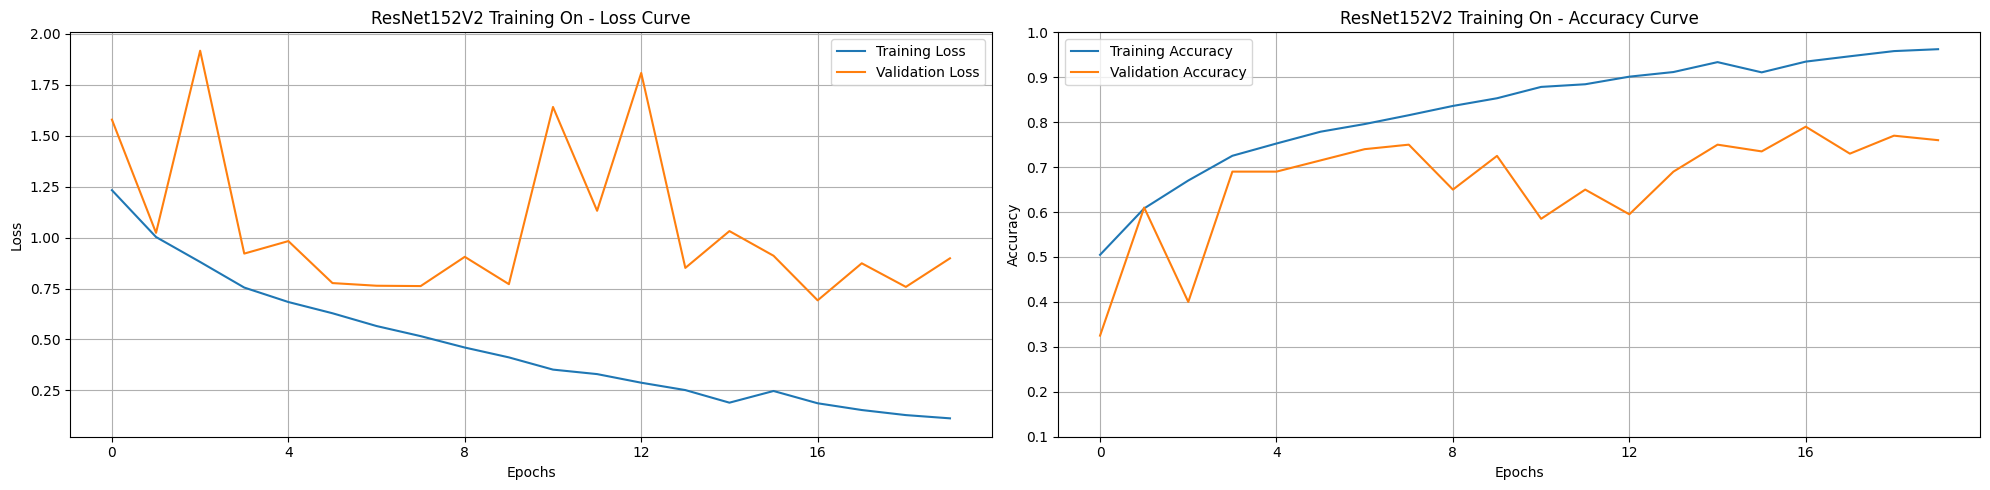

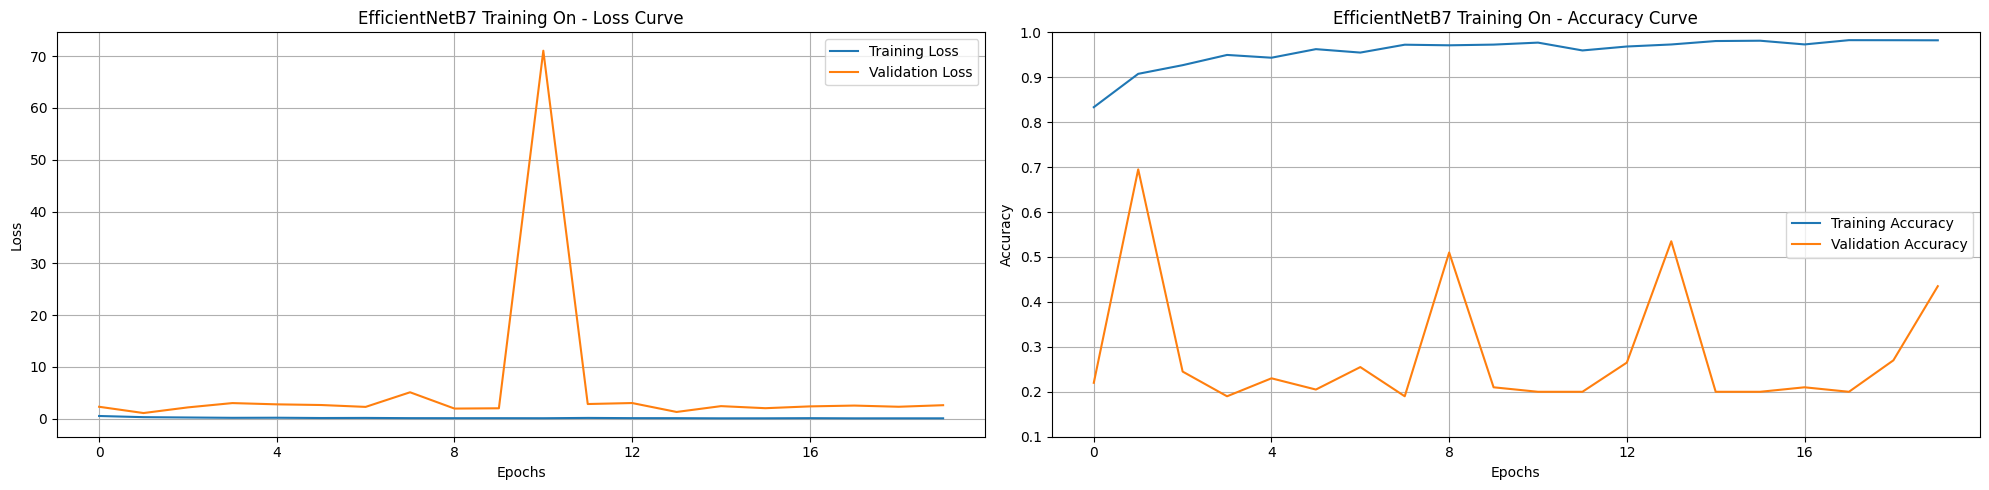

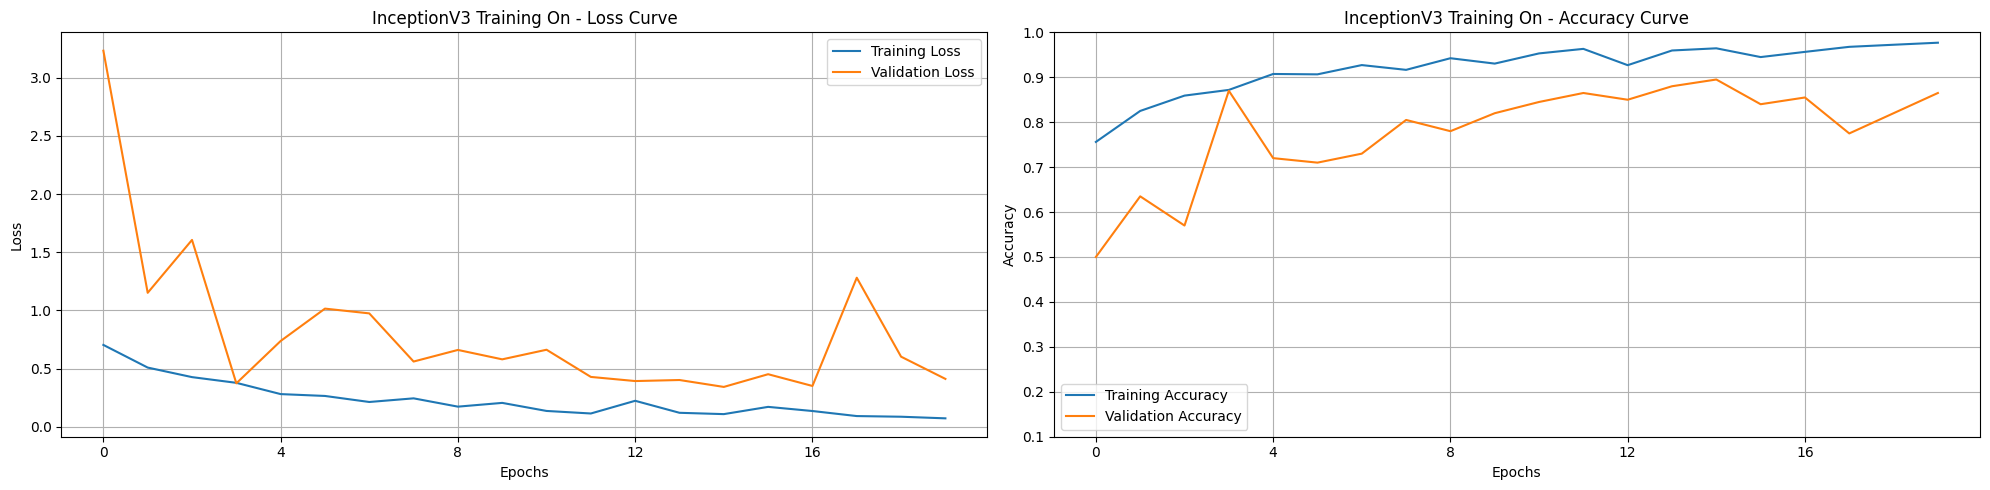

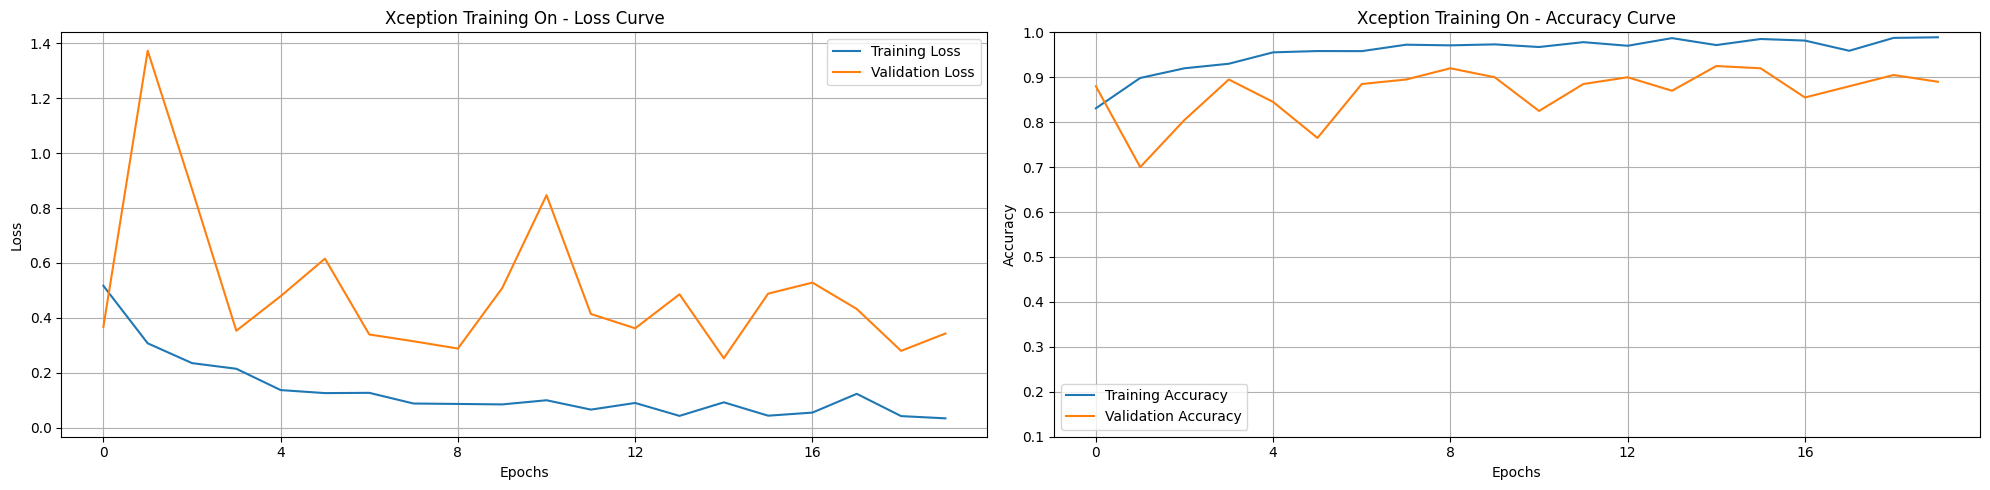

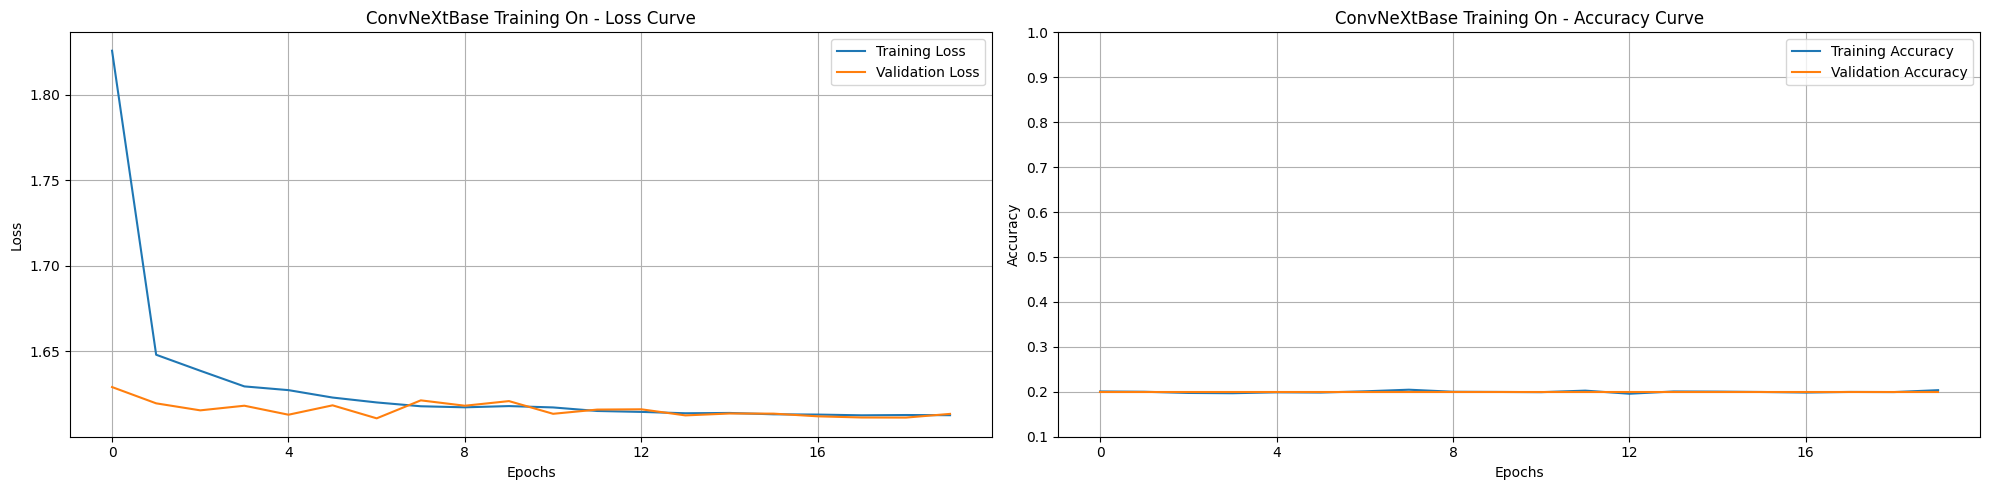

In [ ]:
# Plots, loop over the model training curves (fot training on)
for name, history in HISTORIES.items():

    # Create a new figure for each backbone
    plt.figure(figsize=(20, 5))

    # --- Loss subplot ---
    plt.subplot(1, 2, 1)
    plt.title(f"{name} Training On - Loss Curve")
    plt.plot(history['loss'], label="Training Loss")
    plt.plot(history['val_loss'], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(0, 20, 4))
    plt.grid(True)
    plt.legend()

    # --- Accuracy subplot ---
    plt.subplot(1, 2, 2)
    plt.title(f"{name} Training On - Accuracy Curve")
    plt.plot(history['accuracy'], label="Training Accuracy")
    plt.plot(history['val_accuracy'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.ylim([0.1, 1.0])
    plt.xticks(np.arange(0, 20, 4))
    plt.grid(True)
    plt.legend()

    #save the plot
    save_path = f"/content/drive/My Drive/Colab Notebooks/Capstone/images/{name}Train_On_Acc_Loss.png"
    plt.tight_layout()
    plt.savefig(save_path)

    # show the combined plots
    plt.show()

#### Basckbones with Training On Observations

##### Training Off Table

| Model             | Max Train Accuracy | Median Train Accuracy | Max Val Accuracy | Median Val Accuracy | Training Time (min) |
|-------------------|--------------------|------------------------|------------------|----------------------|----------------------|
| MobileNetV2       | 0.8686             | 0.8637                 | 0.920            | 0.900                | 5.01                 |
| EfficientNetV2B0  | 0.2181             | 0.2118                 | 0.280            | 0.215                | 5.15                 |
| ResNet152V2       | 0.8772             | 0.8681                 | 0.920            | 0.885                | 5.20                 |
| EfficientNetB7    | 0.2178             | 0.2079                 | 0.295            | 0.210                | 8.45                 |
| InceptionV3       | 0.8624             | 0.8564                 | 0.920            | 0.895                | 4.85                 |
| Xception          | 0.8924             | 0.8806                 | 0.905            | 0.885                | 4.97                 |
| ConvNeXtBase      | 0.7795             | 0.7702                 | 0.810            | 0.795                | 5.58                 |


##### Training On Table

| Model            | Max Train Accuracy | Median Train Accuracy | Max Val Accuracy | Median Val Accuracy | Training Time (min) |
|------------------|--------------------|------------------------|------------------|----------------------|----------------------|
| MobileNetV2      | 0.9709             | 0.9427                 | 0.765            | 0.4650               | 8.55                 |
| EfficientNetV2B0 | 0.9860             | 0.9690                 | 0.375            | 0.2050               | 6.84                 |
| ResNet152V2      | 0.9625             | 0.8659                 | 0.790            | 0.7025               | 15.02                |
| EfficientNetB7   | 0.9826             | 0.9718                 | 0.695            | 0.2150               | 26.21                |
| InceptionV3      | 0.9769             | 0.9364                 | 0.895            | 0.8200               | 7.04                 |
| Xception         | 0.9890             | 0.9706                 | 0.925            | 0.8850               | 8.90                 |
| ConvNeXtBase     | 0.2046             | 0.1997                 | 0.200            | 0.2000               | 37.63                |




- with training on, almost every model is subject to overfitting. Training Accuracy is significantly higher than Validation Accuracy and Validation Accuracy never catches up
- every median Validation Accuracy is down (compared to training off), except Xception, which saw a very slight increase
- turning training on is not recommended, as the Validation Accuracy suffers in almost all cases, even up to 50 epochs
- with training on, ConvNeXtBase was similar to EfficientNet. Accuracies were in the 20% range

### Confusion Matrix for EfficientNet

- let's take a look at the confusion matrix to see if we can make any conclusions about why EfficientNet is so poor at 20% Validation Accuracy (with training off)
- modify IMAGE_SIZE = 224 (expected resolution by EfficientNet)

In [ ]:
# Re-run EfficientNetV2B0 with proper image size = 224 and observe Confusion Matrix

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# Create datasets
train_dataset = image_dataset_from_directory(
    train_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

valid_dataset = image_dataset_from_directory(
    valid_dir,
    shuffle=True,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

test_dataset = image_dataset_from_directory(
    test_dir,
    shuffle=False,
    seed=SEED,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

backbone = EfficientNetV2B0(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
# training off
backbone.trainable = False

Ef_model = Sequential([
    Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    backbone,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compile the model
Ef_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
)

# Train the model
Ef_model_history = Ef_model.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        verbose=1
)

# Evaluate on test dataset
test_loss, test_acc = Ef_model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.2f}")

# Save model
Ef_model.save("/content/drive/My Drive/Colab Notebooks/Capstone/models/efficientnetv2b0_224_fruit_classifier.keras")

Found 9700 files belonging to 5 classes.
Found 200 files belonging to 5 classes.
Found 100 files belonging to 5 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 66s 123ms/step - accuracy: 0.2012 - loss: 1.6600 - val_accuracy: 0.2000 - val_loss: 1.6208
Epoch 2/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.1951 - loss: 1.6525 - val_accuracy: 0.2000 - val_loss: 1.6151
Epoch 3/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.1974 - loss: 1.6472 - val_accuracy: 0.1950 - val_loss: 1.6154
Epoch 4/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.2065 - loss: 1.6332 - val_accuracy: 0.2150 - val_loss: 1.6109
Epoch 5/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.2093 - loss: 1.6368 - val_accuracy: 0.2400 - val_loss: 1.6146
Epoch 6/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.2106 - loss: 1.6354 - val_accuracy: 0.1950 - val_loss: 1.6171
Epoch 7/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - accuracy: 0.2052 - loss: 1.6308 - val_accuracy: 0.2250 - val_loss: 1.6240
Epoch 8/20
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.2155 - loss: 1.6288 - val_accura

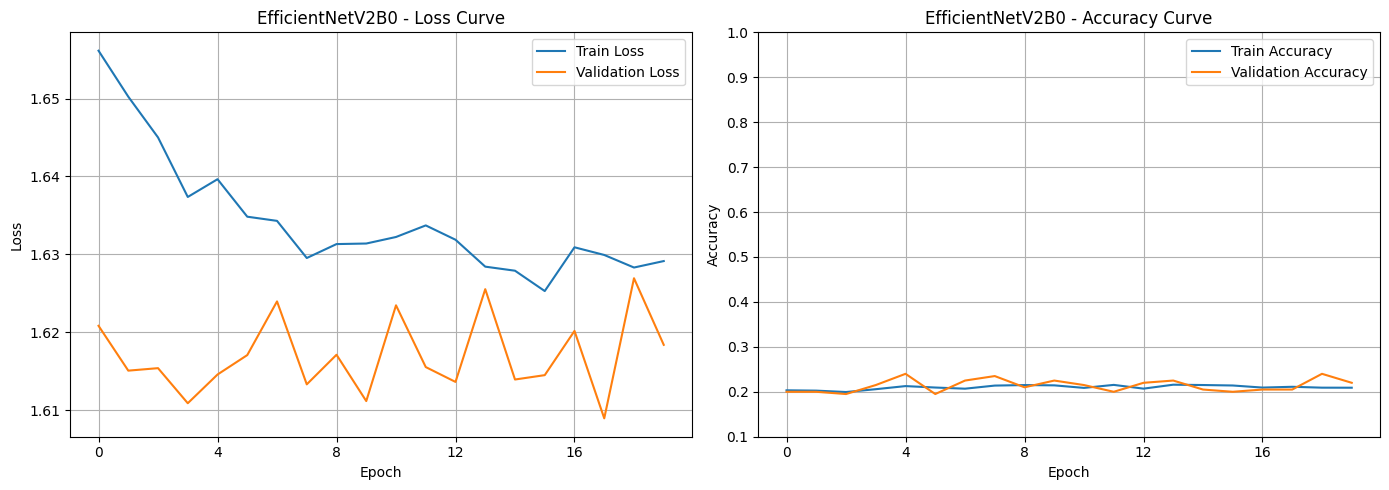

In [ ]:
# Plot training history with Accuracy and Loss
plt.figure(figsize=(14, 5))

# --- Loss subplot ---
plt.subplot(1, 2, 1)
plt.plot(Ef_model_history.history["loss"], label="Train Loss")
plt.plot(Ef_model_history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("EfficientNetV2B0 - Loss Curve")
plt.xticks(np.arange(0, 20, 4))
plt.grid(True)
plt.legend()

# --- Accuracy subplot ---
plt.subplot(1, 2, 2)
plt.plot(Ef_model_history.history["accuracy"], label="Train Accuracy")
plt.plot(Ef_model_history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.1, 1.0])
plt.title("EfficientNetV2B0 - Accuracy Curve")
plt.xticks(np.arange(0, 20, 4))
plt.grid(True)
plt.legend()

# Save and show plot
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/EfficientNetV2B0_244_Acc_Loss.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


<Figure size 800x600 with 0 Axes>

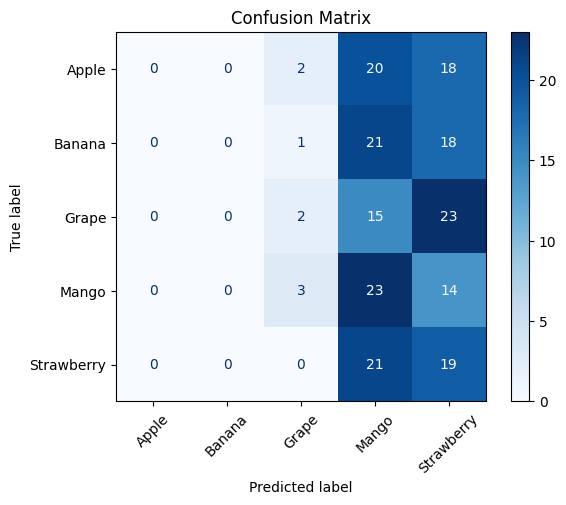

In [ ]:
# Confusion Matrix
class_names = test_dataset.class_names

y_true = []
y_pred = []

for images, labels in valid_dataset:
    # Get model predictions
    predictions = Ef_model.predict(images)

    # Get predicted class indices
    pred_labels = tf.argmax(predictions, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_labels.numpy())

# Step 3: Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/EfficientNetV2B0_CMatrix.png")
plt.show()

### EfficienNet Mislabeled Images Preview

- let's take a look at some mislabeld images and try to reason why the predictions were wrong

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


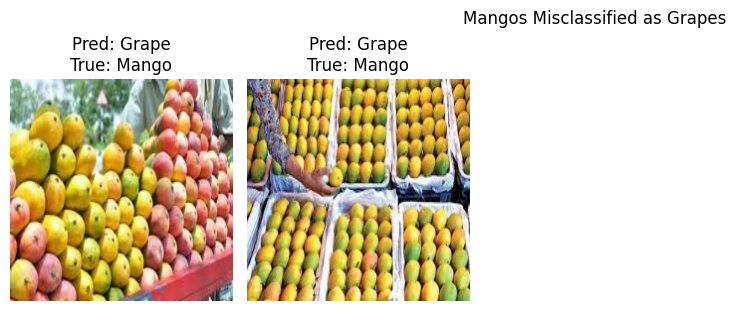

In [ ]:
# show mangoes misclassified as grapes
# Class index map (optional if you know order)
class_names = test_dataset.class_names
class_to_index = {name: idx for idx, name in enumerate(class_names)}

true_class = class_to_index["Mango"]
predicted_class = class_to_index["Grape"]

# Store misclassified examples
mislabeled_images = []

# Loop over the dataset
for images, labels in test_dataset:
    predictions = Ef_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    for i in range(len(labels)):
        if labels[i] == true_class and predicted_labels[i] == predicted_class:
            mislabeled_images.append(images[i])

# Show some misclassified Mango-as-Grape images
plt.figure(figsize=(12, 6))
for i in range(min(10, len(mislabeled_images))):
    plt.subplot(2, 5, i+1)
    plt.imshow(mislabeled_images[i].numpy().astype("uint8"))
    plt.title("Pred: Grape\nTrue: Mango")
    plt.axis("off")

plt.suptitle("Mangos Misclassified as Grapes")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/EfficientNetV2B0_MangosNotGrapes.png")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


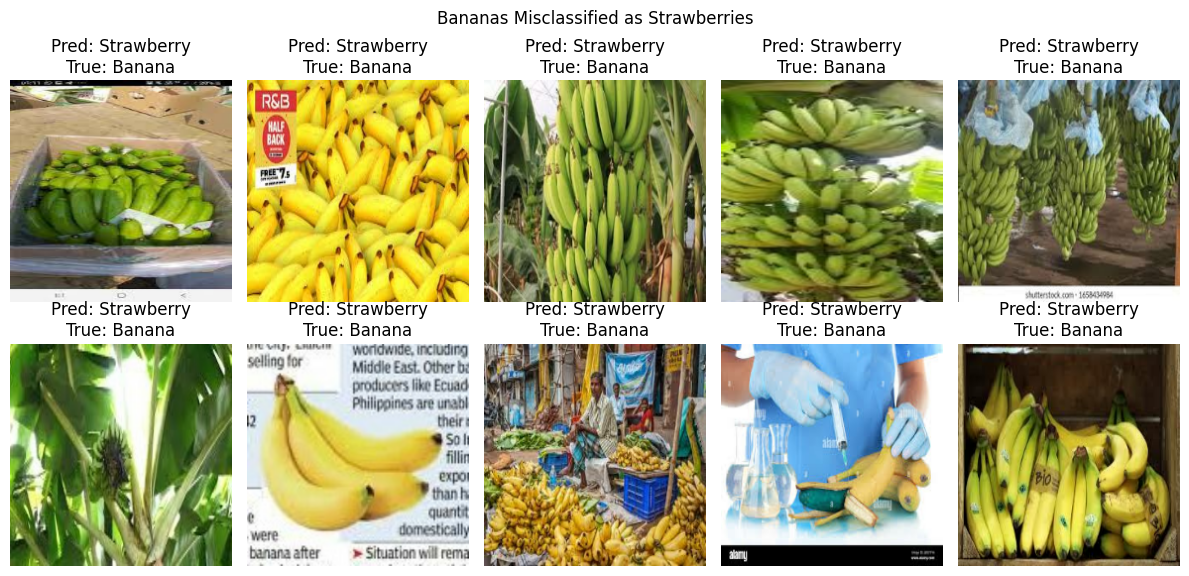

In [ ]:
# show bananas misclassified as strawberries
# Class index map (optional if you know order)
class_names = test_dataset.class_names
class_to_index = {name: idx for idx, name in enumerate(class_names)}

true_class = class_to_index["Banana"]
predicted_class = class_to_index["Strawberry"]

# Store misclassified examples
mislabeled_images = []

# Loop over the dataset
for images, labels in test_dataset:
    predictions = Ef_model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    for i in range(len(labels)):
        if labels[i] == true_class and predicted_labels[i] == predicted_class:
            mislabeled_images.append(images[i])

# Show some misclassified Mango-as-Grape images
plt.figure(figsize=(12, 6))
for i in range(min(10, len(mislabeled_images))):
    plt.subplot(2, 5, i+1)
    plt.imshow(mislabeled_images[i].numpy().astype("uint8"))
    plt.title("Pred: Strawberry\nTrue: Banana")
    plt.axis("off")

plt.suptitle("Bananas Misclassified as Strawberries")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Colab Notebooks/Capstone/images/EfficientNetV2B0_BananasNotStraw.png")
plt.show()

### Confusion Matrix for EfficientNet Observations

- **Conclusion: the confusion matrix gives us more information, but there is no story as to why the EfficientNet model mis-categorized items.  A deeper look into the exact original training pictures and matching them to passed/ failed matches in this analysis is warranted, but out-of-scope for this paper**
- Values shown are for the last epoch = 20.  We expect validation accuracy = 23.5%
- The values along top-left to bottom-right diagonal are the ones that the model got correct
- 3 grapes, 20 mangos, and 24 strawberries were correct, 47 total
- The total validation set is 40 per fruit x 5 fruits = 200
- For this result we are getting 47/200 or 23.5%
- Though we can now see the exact mislabelings, it's not particularly helpful with generating a story
  - The model predicted 0 apples and 0 bananas
  - The model predicted 10 grapes, 3 were correct
    - Since grapes were not in the original training dataset I expected it to predict 0, but that is not the case
  - The model predicted 80 mangoes, 20 of which were correct
  - The model predicted 110 strawberries, 17 of which were correct
- Mislabeled fruits pictures
 - I can see that maybe the prediction of grape from what really is a mango could be because these mangos are in bunches, similar to grapes
  - Looking at bananas predicted to be stawberries - I really have no clue, except maybe the outlines of grouped up bananas  are shaped similar to a strawberry